# Settings

In [2]:
# Load Reticulate function
Sys.setenv(RETICULATE_PYTHON="/home/luca/anaconda3/envs/reticulate/bin/python")
library(reticulate)
reticulate::use_python("/home/luca/anaconda3/envs/reticulate/bin/python")
reticulate::use_condaenv("/home/luca/anaconda3/envs/reticulate")
reticulate::py_module_available(module='anndata') #needs to be TRUE
reticulate::import('anndata') #good to make sure this doesn't error
reticulate::py_module_available(module='leidenalg') #needs to be TRUE
reticulate::import('leidenalg') #good to make sure this doesn't error

[1] TRUE

Module(anndata)

[1] TRUE

Module(leidenalg)

In [3]:
## Patch for annotations in R4.1
# BiocManager::install("Bioconductor/GenomeInfoDb",lib = "/home/luca/R/x86_64-pc-linux-gnu-library/4.1",force = TRUE)
# library(GenomeInfoDb,lib.loc="/home/luca/R/x86_64-pc-linux-gnu-library/4.1")

In [4]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX, cluster, glmgampoi,
               EnsDb.Hsapiens.v86, 
               logr, parallel, future,
               fpc,
               ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x)

Warning message:
“package ‘glmgampoi’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Warning message in p_install(package, character.only = TRUE, ...):
“”
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘glmgampoi’”
Warning message in pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, :
"Failed to install/load:
glmgampoi"


In [5]:
# Load genome
#suppressMessages(annotations <- GetGRangesFromEnsDb(ensdb=EnsDb.Hsapiens.v86))
#genome(annotations) <- 'hg38'
#seqlevelsStyle(annotations) <- 'UCSC'
# Save table
# writeRDS(annotations, "/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")

# Load table
annotations = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/hg38.annotations.rds")
seqlevelsStyle(annotations) <- 'UCSC'
genome(annotations) <- 'hg38'

# Seq info downloaded from: https://github.com/broadinstitute/ichorCNA/issues/84
seq.info = readRDS("/nfs/lab/Luca/Assets/references/Cellranger/seqinfo_hg38_ucsc.rds")

In [6]:
# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)

# set Future
plan("multicore", workers = 4)
# set RAM treshold
## 1000 = 1gb
RAM.tresh = 10000 * 1024^2
options(future.globals.maxSize = RAM.tresh)

In [7]:
# Set directories
base.dir = "/nfs/lab/projects/mega_heart/"
assets.dir = "/nfs/lab/projects/mega_heart/Assets/"

cellranger.links.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/cellranger.symlinks/"

step1.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/"

In [8]:
# Load markers list
cell.markers = read.table(paste(assets.dir, "Cell.markers_3.txt", sep = ""), sep = "\t", header = TRUE)
# Make it long, remove useless column and void markers
cell.markers <- cell.markers %>% gather(Key, marker, c(3:ncol(cell.markers)))
cell.markers = cell.markers[,-3]
cell.markers = cell.markers[cell.markers$marker != "", ]
# Factorize columns
cell.markers$Compartment = factor(cell.markers$Compartment, 
                        levels = c("Muscular", "Vascular", "Neuro", "Stromal", "Immune"))
cell.markers$CellType = factor(cell.markers$CellType,
                        levels = c("CM", "Atrial-CM", "Ventricular-CM",
"SM", "Endothelial", "Endocardial", "Epicardial", "Lymph-Endo", "Pericyte",
"Neuronal", "Fibroblast", "Adipocyte", 
"Macrophage", "T-NK", "NK", "B", "Mast"))

cell.compartment = cell.markers[,-3]

In [9]:
# start log
options("logr.on" = TRUE, "logr.notes" = TRUE)
options("logr.autolog" = TRUE)
options("logr.compact" = TRUE)
options("logr.traceback" = TRUE)
log.file = paste(base.dir, Sys.Date(),".2_SilQC.log", sep="")

In [10]:
log_open(log.file)

[1] "/nfs/lab/projects/mega_heart/log/2024-05-24.2_SilQC.log"

# Load seurat

In [10]:
adata = readRDS(paste(step1.dir, "LV_RV_LA_RA.multiome.mrg.filt.MTless.rds", sep = ""))

# Run SilQC

In [11]:
# Run SilQC by library - we can't have doublets in between lanes anyways right? :) -

In [12]:
# Remove any obvious sub-populations we want to keep
adata = subset(adata, seurat_clusters %in% c("20", "33"), invert = TRUE)

In [13]:
# split adata by library (lane)
log_print(paste("Splitting the object"))
adata_list <- SplitObject(adata, split.by = "library")
log_print(paste("Done"))

[1] "Splitting the object"
[1] "Done"


In [14]:
# Define multiple vectors of cell types
list_of_cells <- list(
  c("Macrophage", "B", "T", "NK", "Mast"),
  c("Endothelial", "Endocardial", "Lymph-Endo"),
  c("Epicardial", "Fibroblast", "SM", "Pericyte", "Adipocyte")
)

# Initialize an empty vector to store results
permutations <- vector("character")

# Generate all permutations of two elements for each vector
for (cells.comb in list_of_cells) {
  for (i in seq_along(cells.comb)) {
    for (j in seq_along(cells.comb)) {
      if (i != j) {  # To avoid pairing elements with themselves
        # Create permutation and format it
        permutations <- c(permutations, paste(cells.comb[i], cells.comb[j], sep = "_"))
      }
    }
  }
}

# Print or use the permutations vector
print(permutations)

 [1] "Macrophage_B"            "Macrophage_T"           
 [3] "Macrophage_NK"           "Macrophage_Mast"        
 [5] "B_Macrophage"            "B_T"                    
 [7] "B_NK"                    "B_Mast"                 
 [9] "T_Macrophage"            "T_B"                    
[11] "T_NK"                    "T_Mast"                 
[13] "NK_Macrophage"           "NK_B"                   
[15] "NK_T"                    "NK_Mast"                
[17] "Mast_Macrophage"         "Mast_B"                 
[19] "Mast_T"                  "Mast_NK"                
[21] "Endothelial_Endocardial" "Endothelial_Lymph-Endo" 
[23] "Endocardial_Endothelial" "Endocardial_Lymph-Endo" 
[25] "Lymph-Endo_Endothelial"  "Lymph-Endo_Endocardial" 
[27] "Epicardial_Fibroblast"   "Epicardial_SM"          
[29] "Epicardial_Pericyte"     "Epicardial_Adipocyte"   
[31] "Fibroblast_Epicardial"   "Fibroblast_SM"          
[33] "Fibroblast_Pericyte"     "Fibroblast_Adipocyte"   
[35] "SM_Epicardial"           

In [15]:
# remove adata to use less space and reset:
rm(adata)
gc(reset = TRUE)

used       (Mb)    gc trigger  (Mb)     max used   (Mb)   
Ncells   13593932   726.0    22800147   1217.7   13593932   726.0
Vcells 9916357404 75655.9 24945647550 190320.2 9916357404 75655.9

In [16]:
# Setup
exclusion = permutations

tresh = -0.5
out.dir = paste0(step1.dir, "silQC/")

In [17]:
# Define the cleaning function
Sil.QC <- function(adata, exclusion, tresh, out.dir) {
  gc(reset = TRUE)
  # Create all unique combinations without repetitions (we do this on a sample level to avoid problems)
  celltypes = unique(adata$celltypes)
  all_combinations <- combn(celltypes, 2, simplify = TRUE)
  celltype.1.ls <- all_combinations[1, ]
  celltype.2.ls <- all_combinations[2, ]

  # Save library ID
  library.id = as.character(unique(adata$library))
  log_print(paste("Processing: ", library.id))
  # Create empty variables
  cell.remove.all <- NULL
  qc.data <- NULL
  
  for (i in seq_along(celltype.1.ls)) {
    # Setup variables
    celltype.1 <- celltype.1.ls[i]
    celltype.2 <- celltype.2.ls[i]
    contrast <- paste0(celltype.1, "_", celltype.2)
      
    # Skip exclusions
    if (contrast %in% exclusion) {
      log_print(paste0(" - ", library.id, ": ", contrast, " was excluded"))
      next
    }
      
    # Subset to those celltypes
    adata.use <- subset(adata, celltypes %in% c(celltype.1, celltype.2))
    
    # Check if there are enough clusters to compute silhouette scores
    clusters <- adata.use$celltypes
    if (length(unique(clusters)) < 2) {
      log_print(paste0(" - ", library.id, ": ", contrast, " skipped due to insufficient clusters"))
      next
    }
    
    # Calculate silhouette score
    dist.matrix <- stats::dist(x = Embeddings(object = adata.use[["umap.wnn"]]))
    clusters <- adata.use$celltypes
    sil <- silhouette(x = as.numeric(x = as.factor(x = clusters)), dist = dist.matrix)
    # Add to adata
    adata.use$sil <- sil[, 3]
    adata.use$sil.qc <- ifelse(adata.use$sil > tresh, "Pass", "Fail")
    
    # Extract barcodes using these indices
    cell.remove <- rownames(adata.use@meta.data)[which(adata.use@meta.data$sil.qc == "Fail")]    
    cell.remove.all <- c(cell.remove.all, cell.remove)

    # Populate QC dataframe
    qc.tmp <- data.frame(library = library.id,
                         celltype.1 = celltype.1,
                         celltype.2 = celltype.2,
                         contrast = contrast,
                         cells.remove = length(cell.remove))
    qc.data <- rbind(qc.data, qc.tmp)

    # Grab the vector to plot
    sil_scores <- FetchData(adata.use, vars = "sil")

    # Make figure
    file <- paste(out.dir, library.id, "--", contrast, "_silhouetteQC.png", sep = "")
    png(file, width = 2304, height = 1536)
    gg1 <- ggplot(sil_scores, aes(x = factor(1), y = sil)) +
      geom_violin(trim = FALSE) +
      labs(title = "Violin Plot of sil_scores",
           x = "",
           y = "\n sil_scores") +
      theme_bw() +
      theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
      geom_hline(yintercept = tresh, linetype = "dashed", color = "red")
    gg2 <- ggplot(sil_scores, aes(x = sil)) +
      geom_histogram(bins = 100, fill = "blue", color = "black") +
      labs(title = "Histogram of sil_scores",
           x = " \n sil_scores",
           y = "Count") +
      theme_bw() +
      geom_vline(xintercept = tresh, linetype = "dashed", color = "red")
    gg3 <- DimPlot(adata.use, reduction = 'umap.wnn', group.by = "sil.qc", label = TRUE, label.size = 6, repel = TRUE) +
      ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
    gg4 <- DimPlot(adata.use, reduction = 'umap.wnn', group.by = "celltypes", label = TRUE, label.size = 6, repel = TRUE) +
      ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')

    # Save
    figure <- ggarrange(gg1, gg2, gg3, gg4, ncol = 2, nrow = 2, legend = "none")
    print(annotate_figure(figure, top = text_grob(paste0(contrast, "\n"),
                                                 color = "Black", face = "bold", size = 24)))
    dev.off()
  }
  return(list(qc_data = qc.data, cell_remove_all = cell.remove.all))
  log_print(paste(library.id, "--", contrast, " Done!"))
}

In [18]:
# EVERY CORE WILL HAVE 4 Threads -> consider that when running this
cores <- 8
cl <- makeCluster(cores)
setDefaultCluster(cl)

result_list = NULL
log_print(paste("Starting the analysis"))

result_list <- mclapply(adata_list, Sil.QC,
                        exclusion = exclusion,
                        tresh = tresh,
                        out.dir = out.dir,
                        mc.cores = cores)
log_print(paste("Done"))

[1] "Starting the analysis"
[1] "Done"


In [19]:
# Clean up the parallel backend
setDefaultCluster(NULL)
stopCluster(cl)

In [20]:
# Combine results
qc_data_combined <- do.call(rbind, lapply(result_list, function(x) x$qc_data))
cell_remove_combined <- unlist(lapply(result_list, function(x) x$cell_remove_all))

In [21]:
cell_remove_combined = unique(cell_remove_combined)

## per library - stats

In [22]:
# Load adata again
adata.bckp = readRDS(paste(step1.dir, "LV_RV_LA_RA.multiome.mrg.filt.MTless.rds", sep = ""))

In [23]:
qc_data_combined = qc_data_combined %>%
            dplyr::arrange(-cells.remove) %>%
            dplyr::filter(cells.remove > 2)

In [24]:
# Making an overall dataframe of what was removed (not by sample)
qc_data_plot = qc_data_combined %>%
            dplyr::group_by(contrast) %>%
            dplyr::mutate(cells.remove.all = sum(cells.remove)) %>%
            dplyr::distinct(contrast, .keep_all = TRUE) %>%
            dplyr::select(-library) %>%
            dplyr::filter(cells.remove.all > 5) %>%
            dplyr::ungroup()

gg0 = ggplot(qc_data_plot, aes(x= reorder(contrast, +cells.remove.all), y = cells.remove.all)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = paste0("Cells Removed: ", length(unique(cell_remove_combined))),
       x = "Contrast",
       y = "Number of Cells to Remove") +
  theme_bw() +
  coord_flip()+
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Check if we are removing cells from specific samples or conditions
cells = colnames(adata.bckp[["RNA"]])
covariant = as.character(adata.bckp@meta.data$library)
cells.covariant = as.data.frame(cbind(cells, 
                       covariant))
cells.covariant = dplyr::filter(cells.covariant, 
                               cells %in% cell_remove_combined)
# plot
cells.covariant = as.data.frame(table(cells.covariant$covariant))
colnames(cells.covariant)[1] = "covariant"
width = 0.8
position = position_dodge(width = width)

gg1 = ggplot(cells.covariant, aes(x= covariant, y = Freq, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = "library") +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            ylim(0, 300)+
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            geom_text(hjust = -0.3, size = 2.9, position = position_dodge(width = width))+
            coord_flip()


# Check if we are removing cells from specific samples or conditions
cells.condition = as.data.frame(table(adata.bckp$condition))

cells = colnames(adata.bckp[["RNA"]])
covariant = as.character(adata.bckp@meta.data$condition)
cells.covariant = as.data.frame(cbind(cells, 
                       covariant))
cells.covariant = dplyr::filter(cells.covariant, 
                               cells %in% cell_remove_combined)

cells.covariant = as.data.frame(table(cells.covariant$covariant))
colnames(cells.covariant)[1] = "covariant"

cells.covariant$proportion = (cells.covariant$Freq/cells.condition$Freq)*100
width = 0.8
position = position_dodge(width = width)


gg2 = ggplot(cells.covariant, aes(x= covariant, y = Freq, label = paste0(round(proportion, 2), "%"))) + 
            theme_bw () +
            labs(y= "", x = "", title = "condition") +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            ylim(0, 300)+
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            geom_text(hjust = -0.3, size = 2.9, position = position_dodge(width = width))+
            coord_flip()

In [25]:
# Check if we are removing cells from specific samples or conditions
cells.condition = as.data.frame(table(adata.bckp$celltypes, adata.bckp$condition))
colnames(cells.condition)[1] = "celltypes"
colnames(cells.condition)[2] = "condition"
colnames(cells.condition)[3] = "Freq_Tot"

cells = colnames(adata.bckp[["RNA"]])
covariant = as.character(adata.bckp@meta.data$celltypes)
covariant2 = as.character(adata.bckp@meta.data$condition)
cells.covariant = as.data.frame(cbind(cells, 
                       covariant, covariant2))
cells.covariant = dplyr::filter(cells.covariant, 
                               cells %in% cell_remove_combined)

colnames(cells.covariant)[2] = "celltypes"
colnames(cells.covariant)[3] = "condition"
cells.covariant = as.data.frame(table(cells.covariant$celltypes, cells.covariant$condition))
colnames(cells.covariant)[1] = "celltypes"
colnames(cells.covariant)[2] = "condition"
cells.covariant = merge(cells.covariant, cells.condition, by = c("celltypes", "condition"), all.x = TRUE)
cells.covariant$proportion = (cells.covariant$Freq/cells.covariant$Freq_Tot)*100

gg3 = ggplot(cells.covariant, aes(x= celltypes, y = Freq, fill = condition, label = paste0(round(proportion, 2), "%"))) + 
            theme_bw () +
            labs(y= "", x = "", title = "condition") +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            ylim(0, 700)+
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            geom_text(hjust = -0.3, size = 2.9, position = position_dodge(width = width))+
            coord_flip()

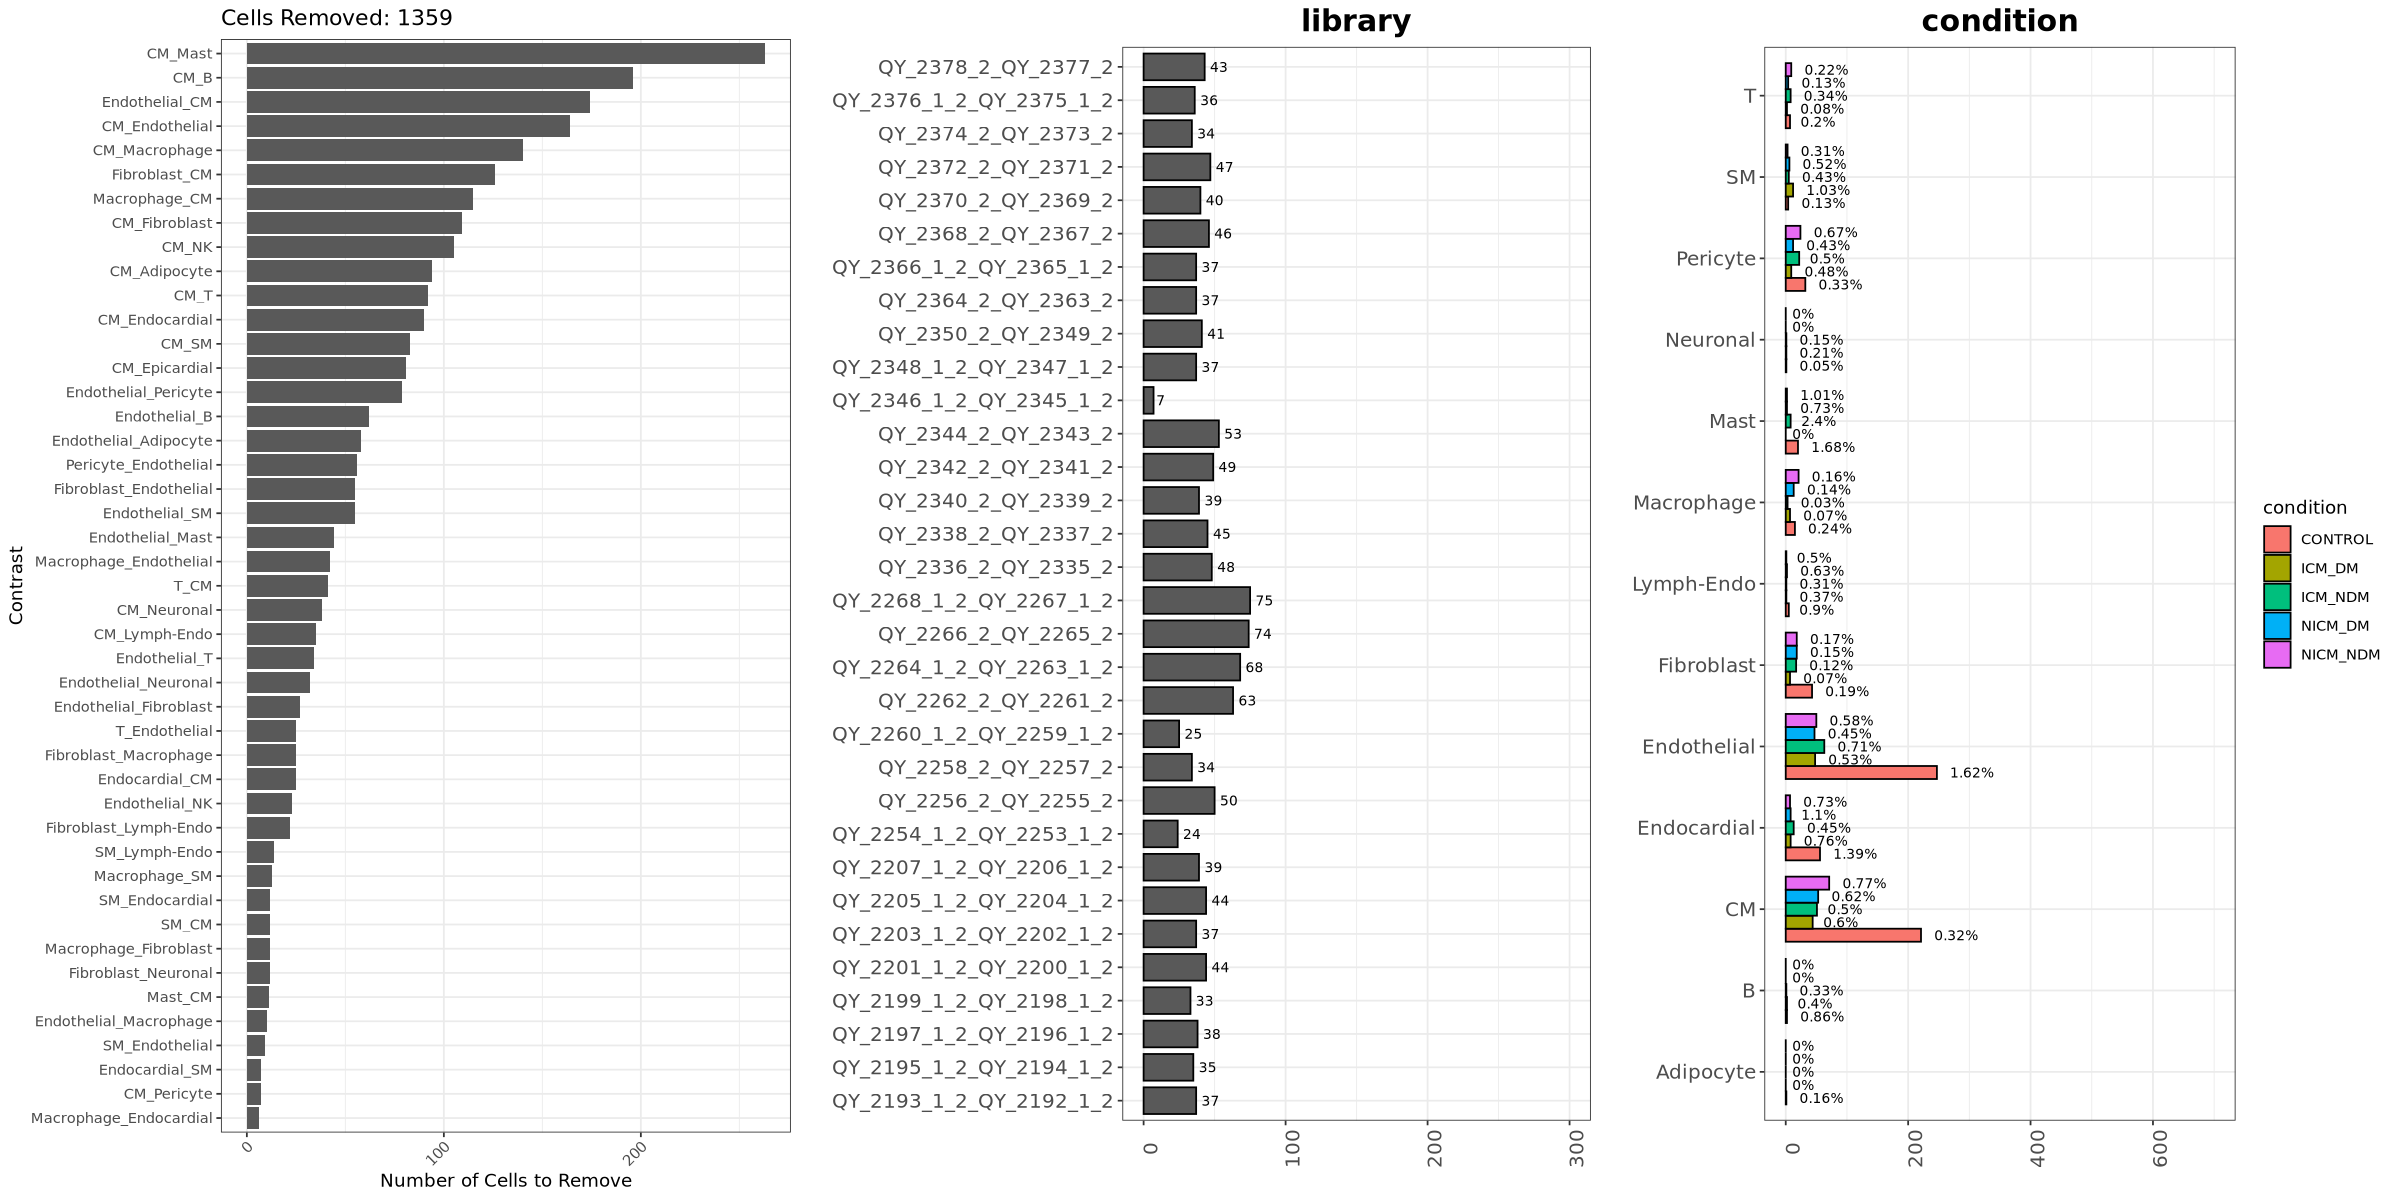

In [26]:
options(repr.plot.width=20, repr.plot.height=10)
ggarrange(gg0, gg1, gg3,
          ncol = 3, nrow = 1)

## UMAP

In [27]:
adata.check = subset(adata.bckp, cells = cell_remove_combined)

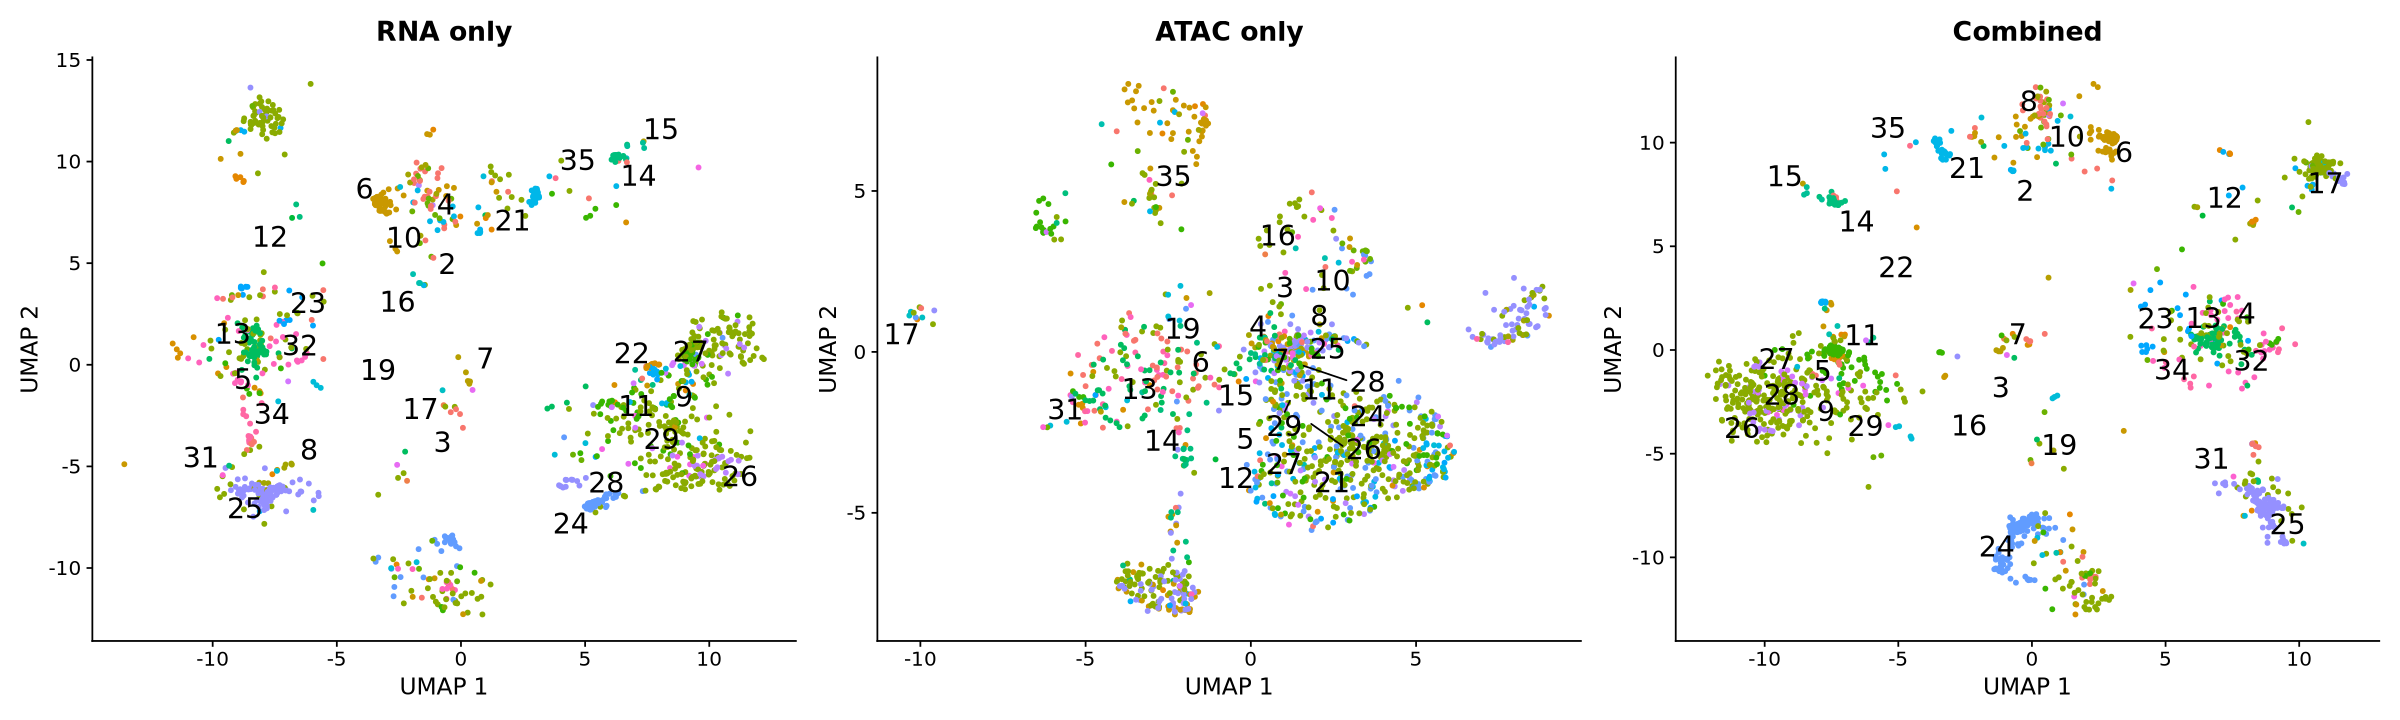

In [28]:
options(repr.plot.width=20, repr.plot.height=6)
p1 <- DimPlot(adata.check, reduction='umap.rna', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata.check, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata.check, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))

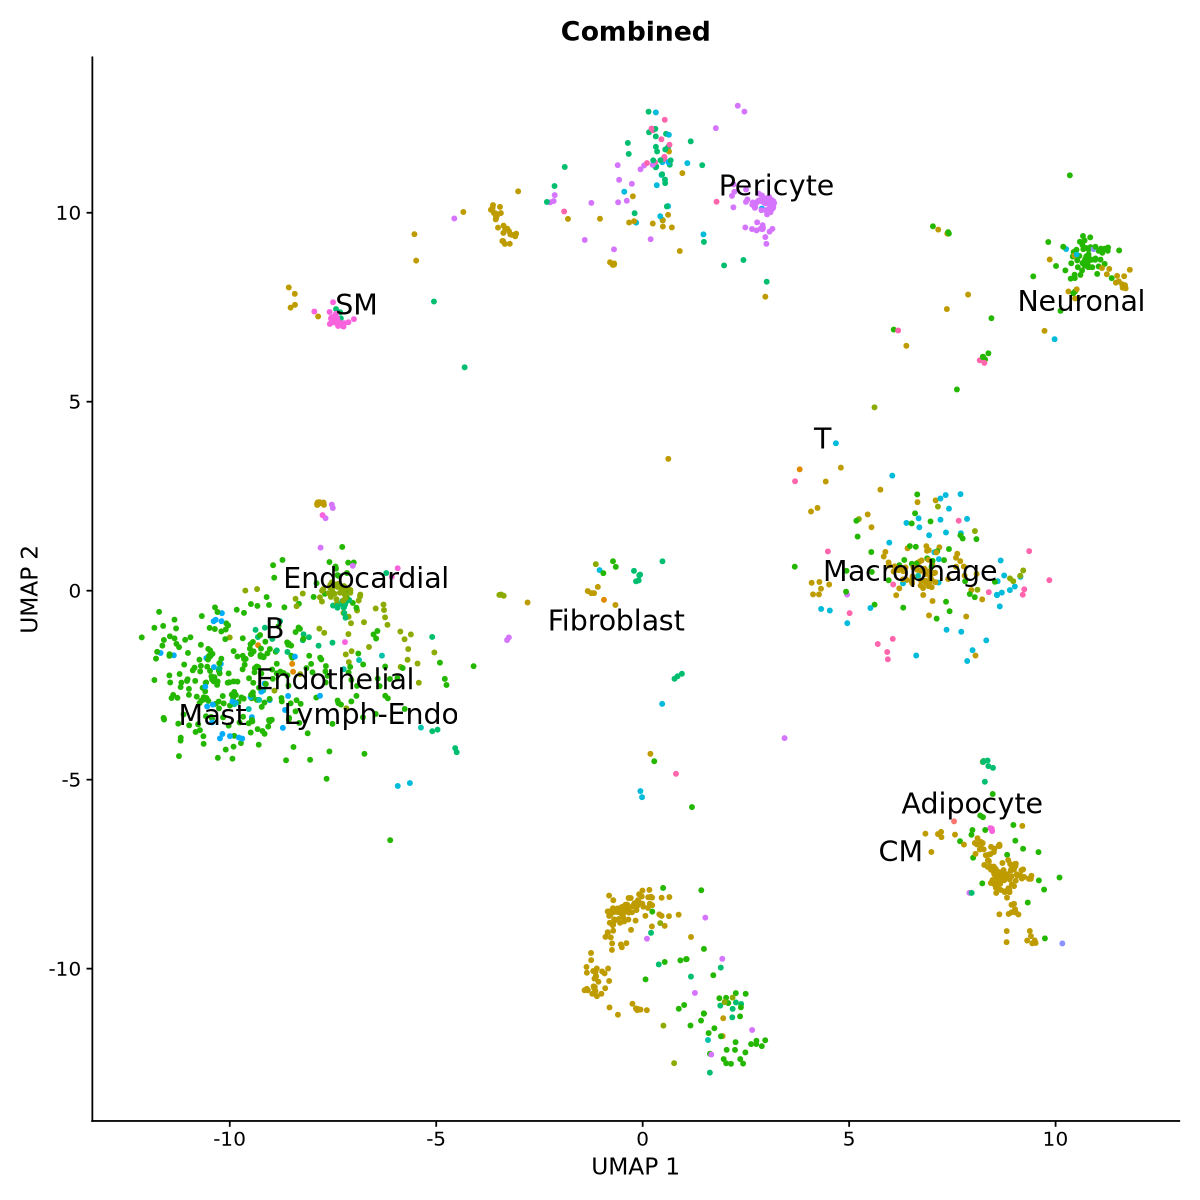

In [29]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata.check, reduction='umap.wnn', group.by = "celltypes", label=TRUE, label.size=6, repel=TRUE) +
              ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') & NoLegend()

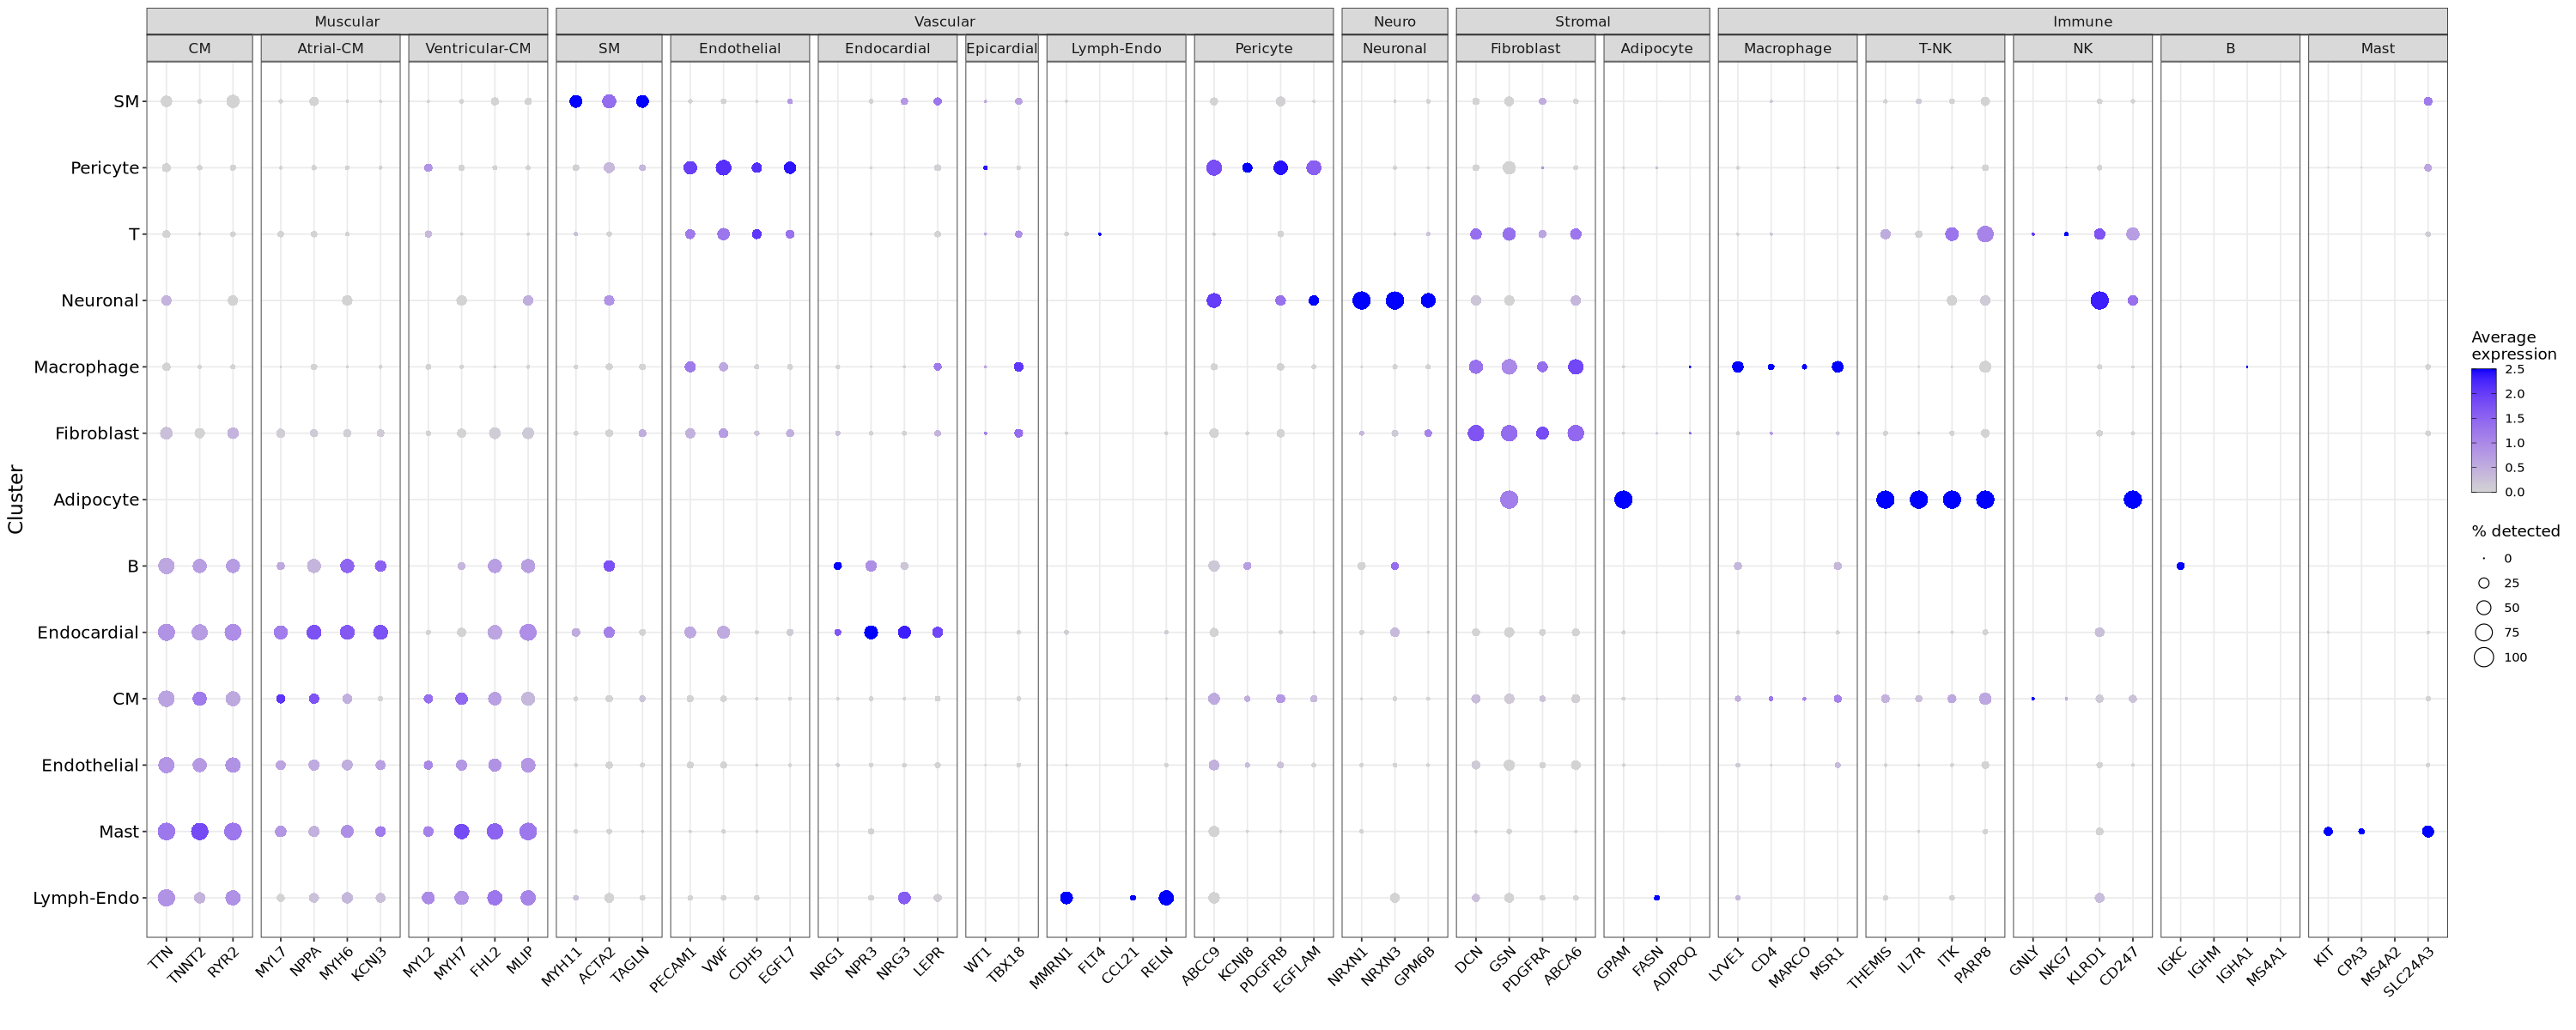

In [30]:
# Check marker genes
g = DotPlot(adata.check, assay='SCT', features=cell.markers$marker, cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=25, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
    figure

## Removed vs kept features

In [31]:
adata.bckp$sil.qc <- ifelse(rownames(adata.bckp@meta.data) %in% cell_remove_combined, "FAIL", "PASS")
# Create a combined metadata column to summarize celltypes and qc results
adata.bckp$cluster_sil.qc = paste0(adata.bckp$celltypes, "--", adata.bckp$sil.qc)

In [32]:
# RNA plots
    p1 <- VlnPlot(adata.bckp, features='nFeature_RNA', split.by = "sil.qc", group.by = 'celltypes', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata.bckp$nFeature_RNA, na.rm = TRUE), linetype='dashed', lw=2) + 
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())
    p2 <- VlnPlot(adata.bckp, features='percent.mt', split.by = "sil.qc", group.by = 'celltypes', pt.size=0) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata.bckp$percent.mt, na.rm = TRUE), linetype='dashed')+
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())

# ATAC plots
    p3 <- VlnPlot(adata.bckp, features='atac_fragments', split.by = "sil.qc", group.by = 'celltypes', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata.bckp$atac_fragments, na.rm = TRUE), linetype='dashed', lw=2)+
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())
    p4 <- VlnPlot(adata.bckp, features='TSS.enrichment', split.by = "sil.qc", group.by = 'celltypes', pt.size=0) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata.bckp$TSS.enrichment, na.rm = TRUE), linetype='dashed', lw=2)+
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())

The default behaviour of split.by has changed.
Separate violin plots are now plotted side-by-side.
To restore the old behaviour of a single split violin,
set split.plot = TRUE.
      
This message will be shown once per session.



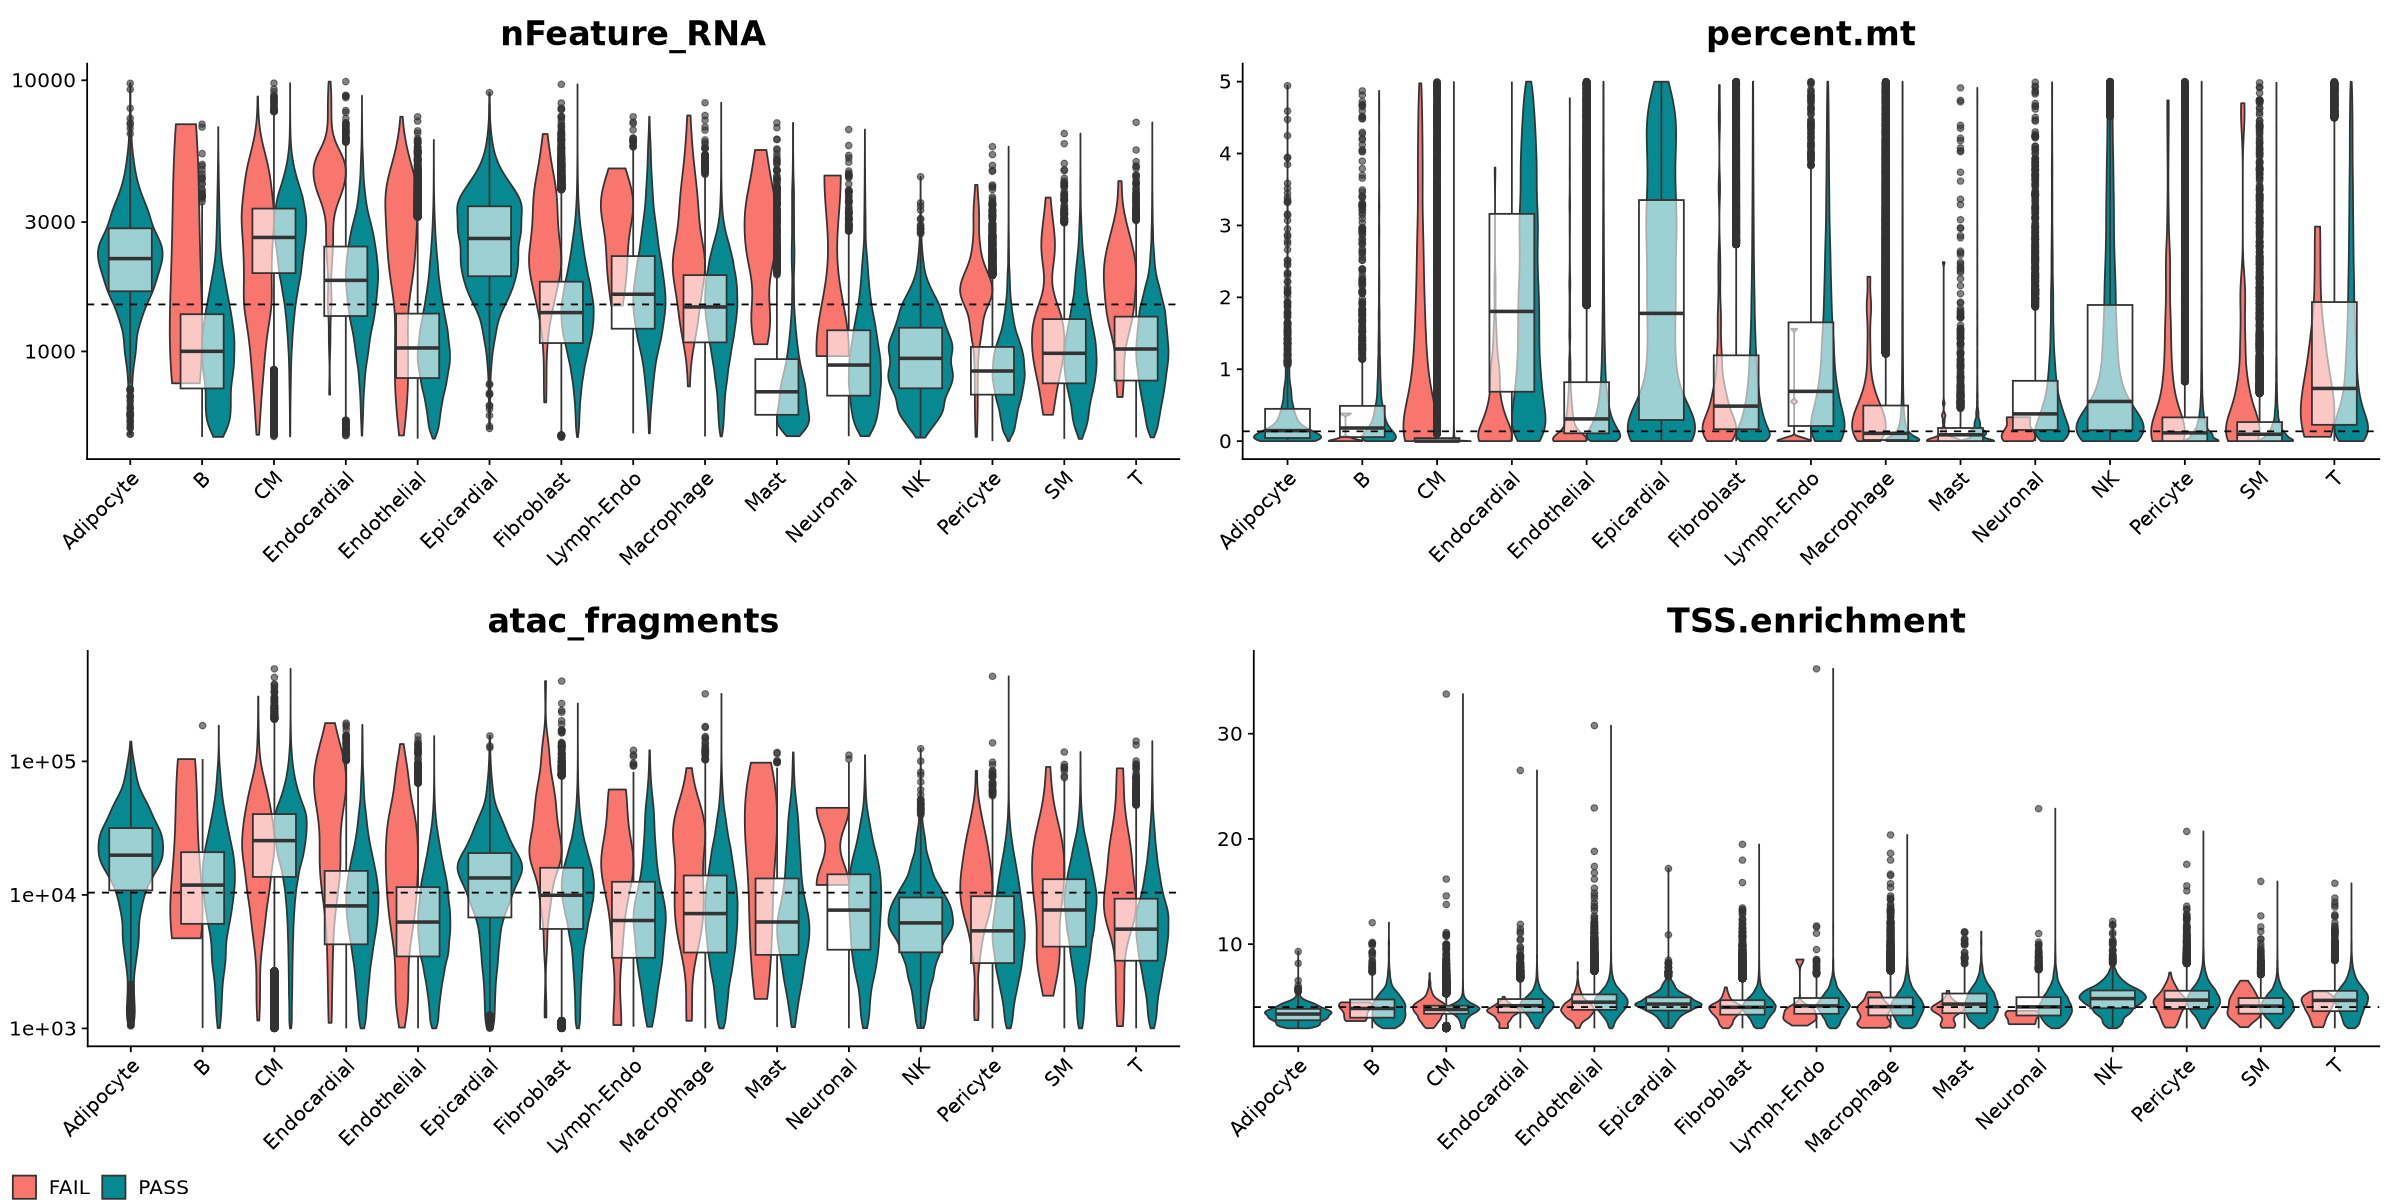

In [33]:
options(repr.plot.height = 10, repr.plot.width = 20)
ggarrange(p1, p2, p3, p4, 
          ncol = 2, nrow = 2,
          common.legend = TRUE, legend="bottom")

# Remove cells

In [34]:
adata <- subset(adata.bckp, cells = cell_remove_combined, invert = TRUE)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



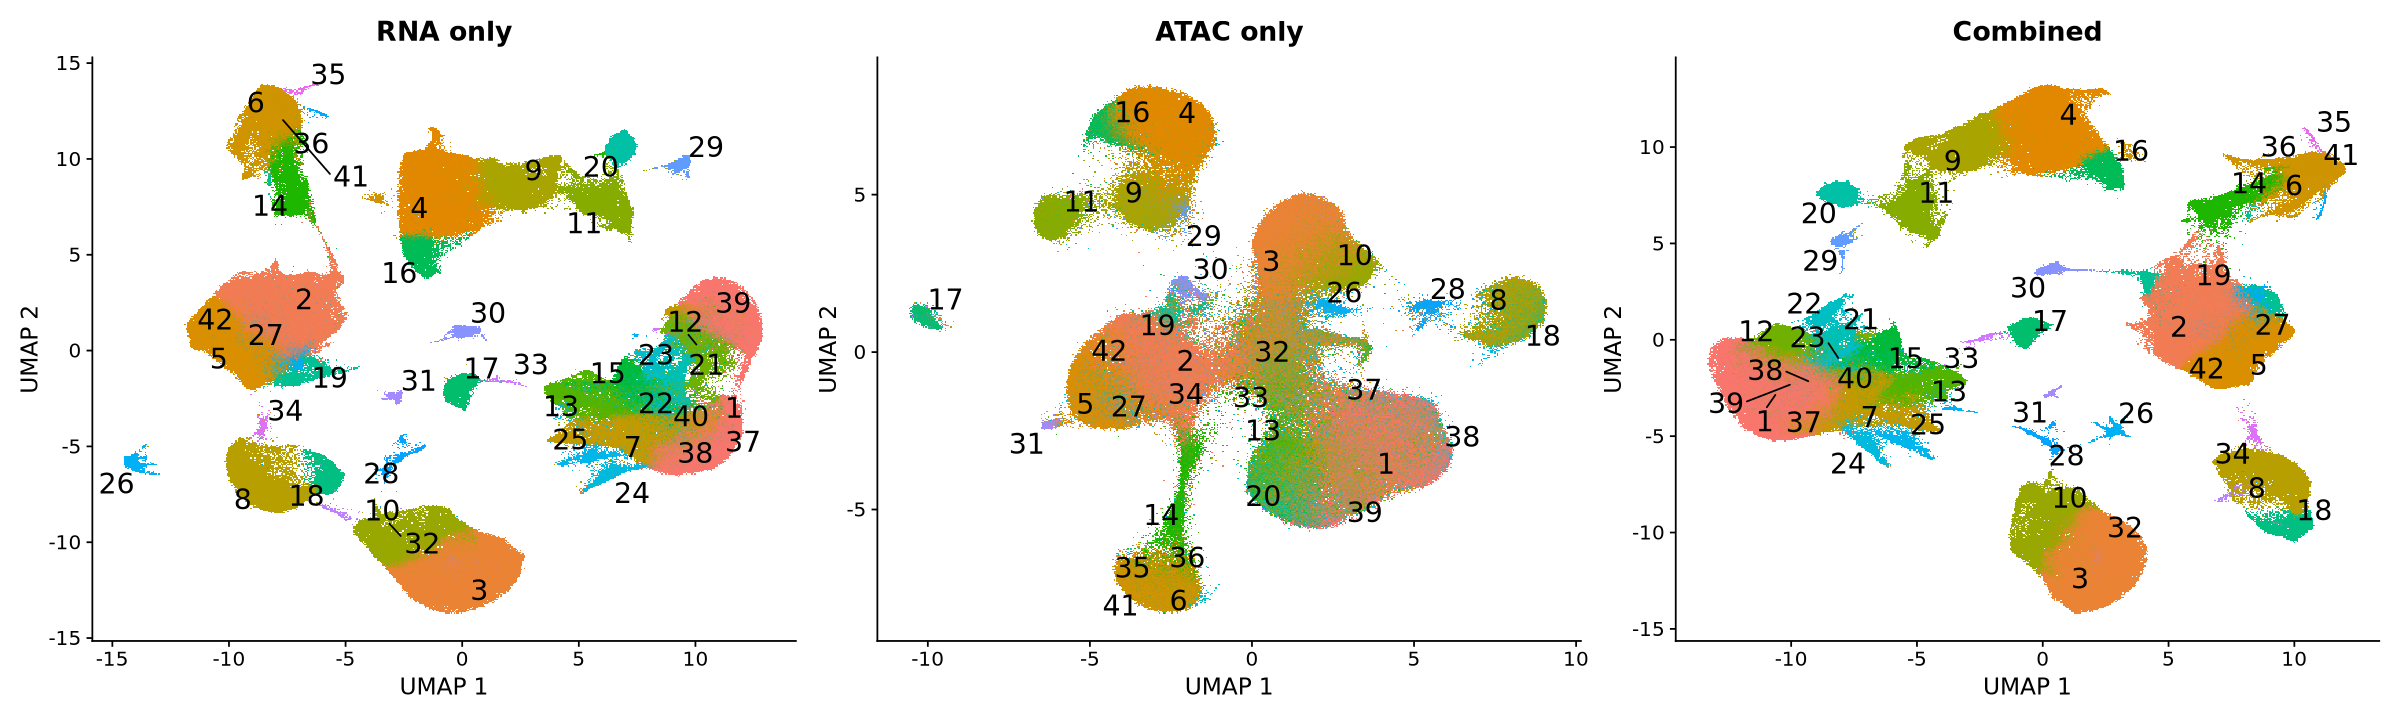

In [35]:
options(repr.plot.width=20, repr.plot.height=6)
p1 <- DimPlot(adata, reduction='umap.rna', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



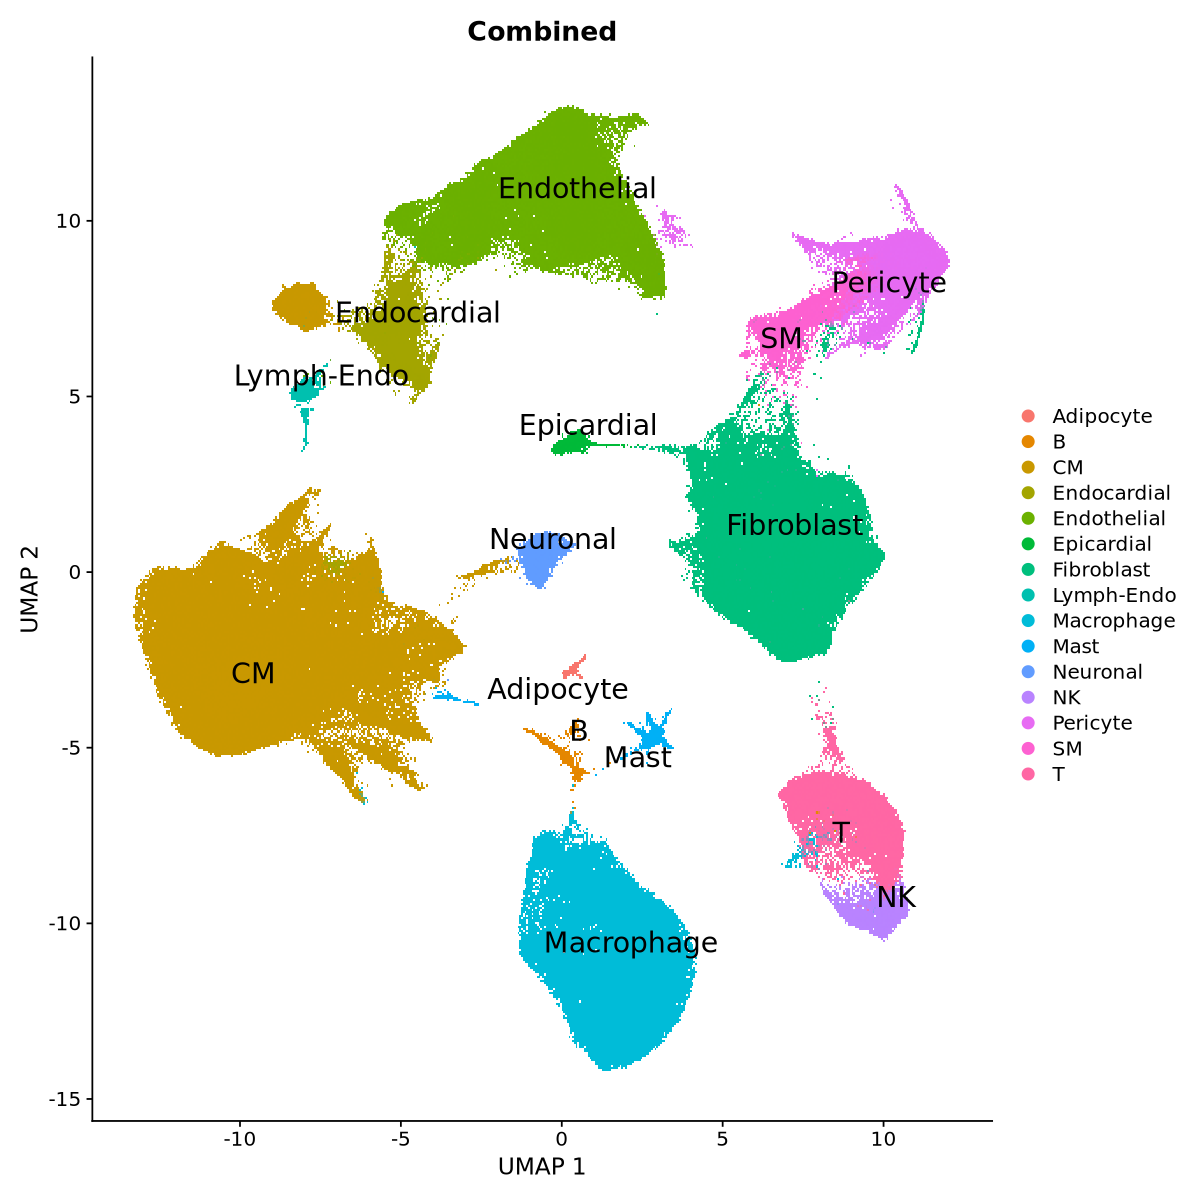

In [36]:
options(repr.plot.width=10, repr.plot.height=10)
DimPlot(adata, reduction='umap.wnn', group.by = "celltypes", label=TRUE, label.size=6, repel=TRUE) +
              ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')

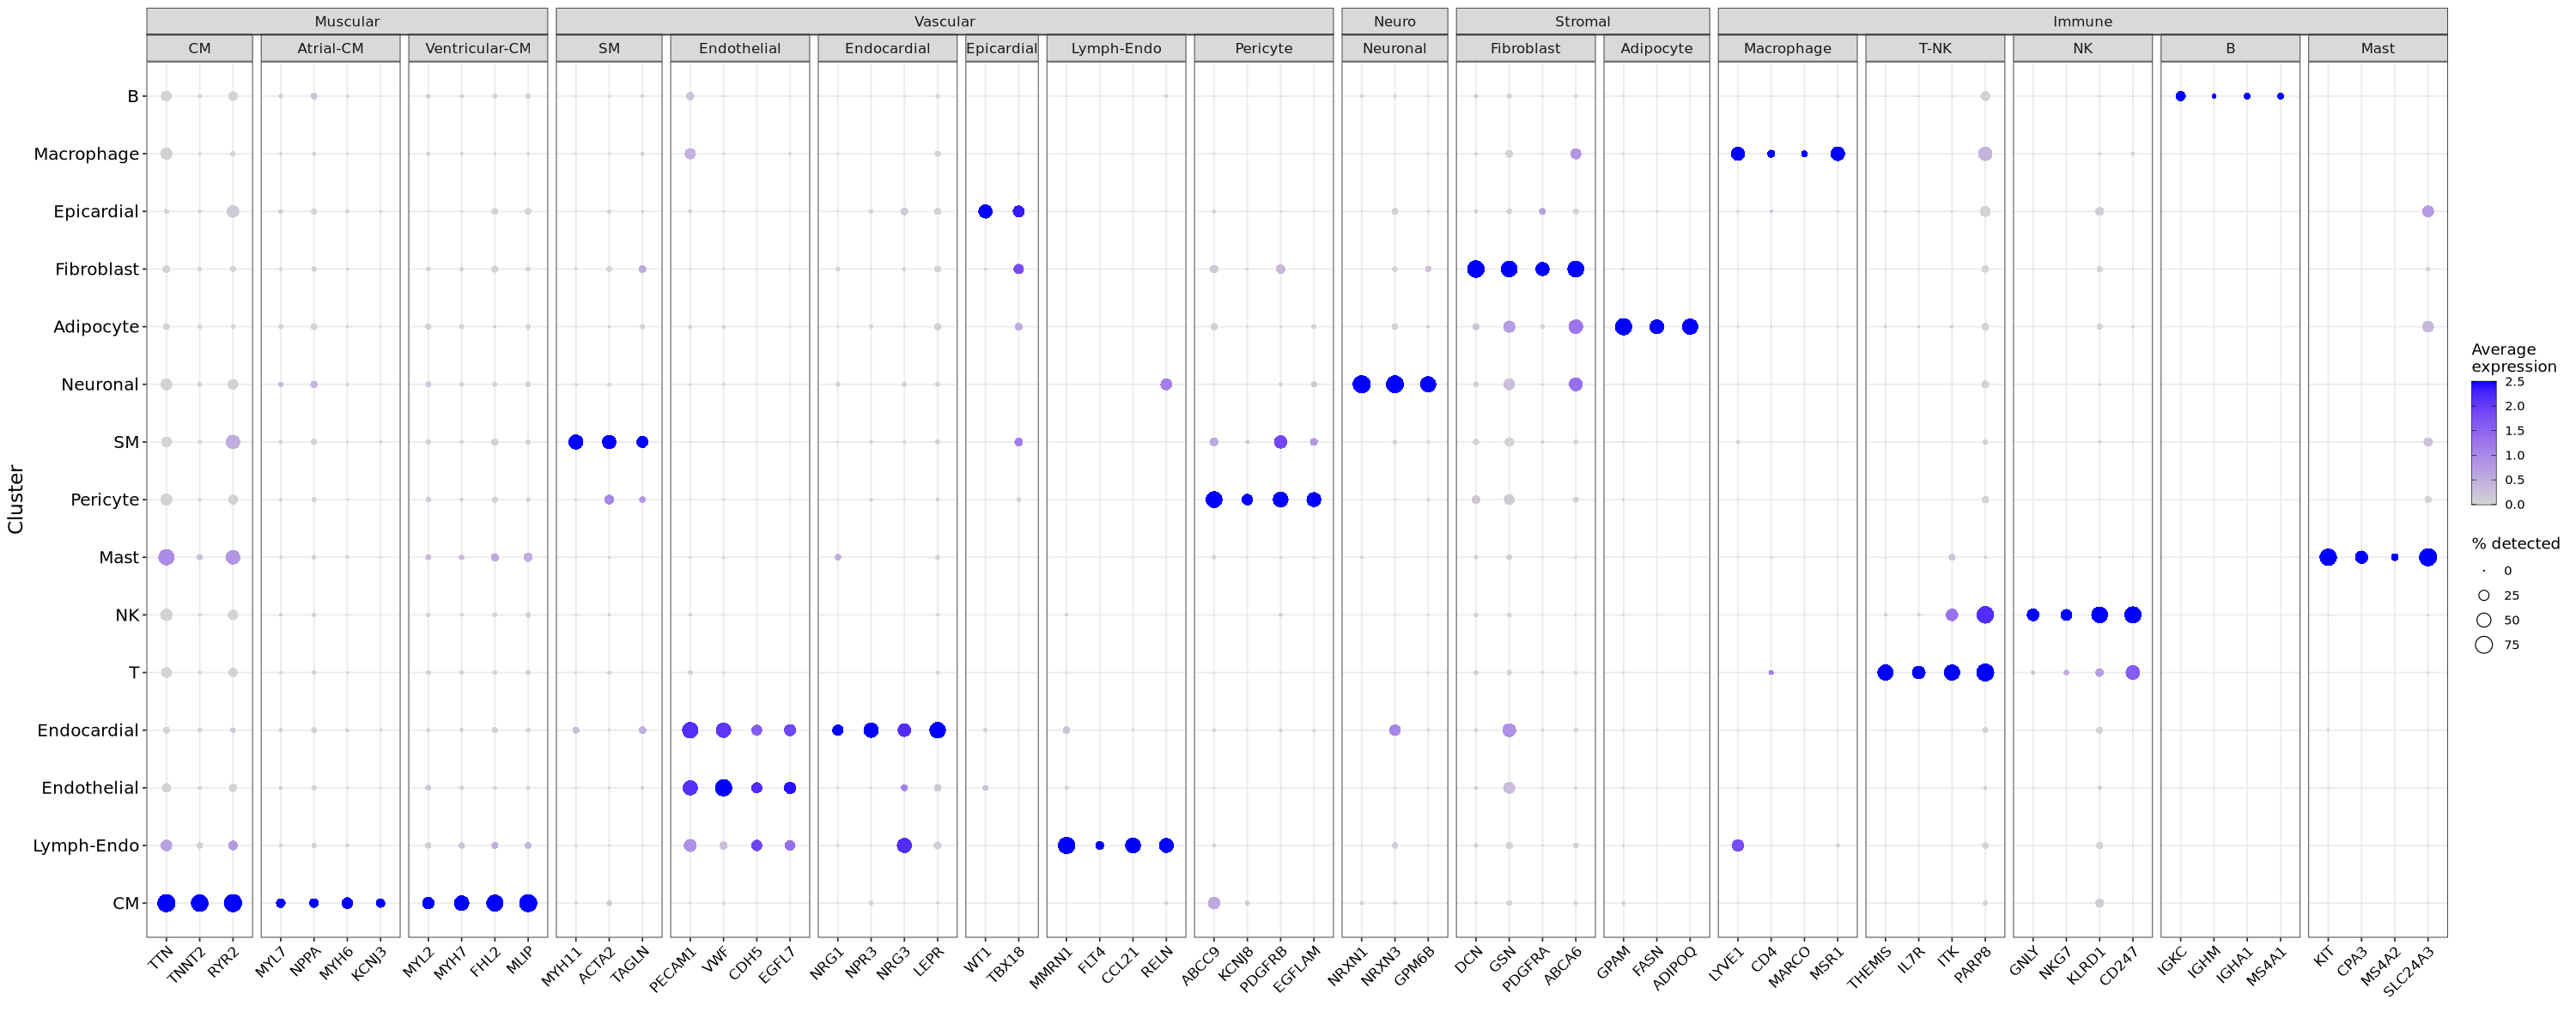

In [37]:
# Check marker genes
g = DotPlot(adata, assay='SCT', features=cell.markers$marker, cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=25, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
    figure

In [38]:
# RNA plots
    p1 <- VlnPlot(adata, features='nCount_RNA', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_RNA, na.rm = TRUE), linetype='dashed', lw=2) + 
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())
    p2 <- VlnPlot(adata, features='nFeature_RNA', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_RNA, na.rm = TRUE), linetype='dashed', lw=2) + 
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())
    p3 <- VlnPlot(adata, features='percent.mt', pt.size=0) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$percent.mt, na.rm = TRUE), linetype='dashed')+
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())

# ATAC plots
    p4 <- VlnPlot(adata, features='nCount_ATAC', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nCount_ATAC, na.rm = TRUE), linetype='dashed', lw=2) + 
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())
    p5 <- VlnPlot(adata, features='atac_fragments', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$atac_fragments, na.rm = TRUE), linetype='dashed', lw=2)+
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())
    p6 <- VlnPlot(adata, features='TSS.enrichment', pt.size=0) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$TSS.enrichment, na.rm = TRUE), linetype='dashed', lw=2)+
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())

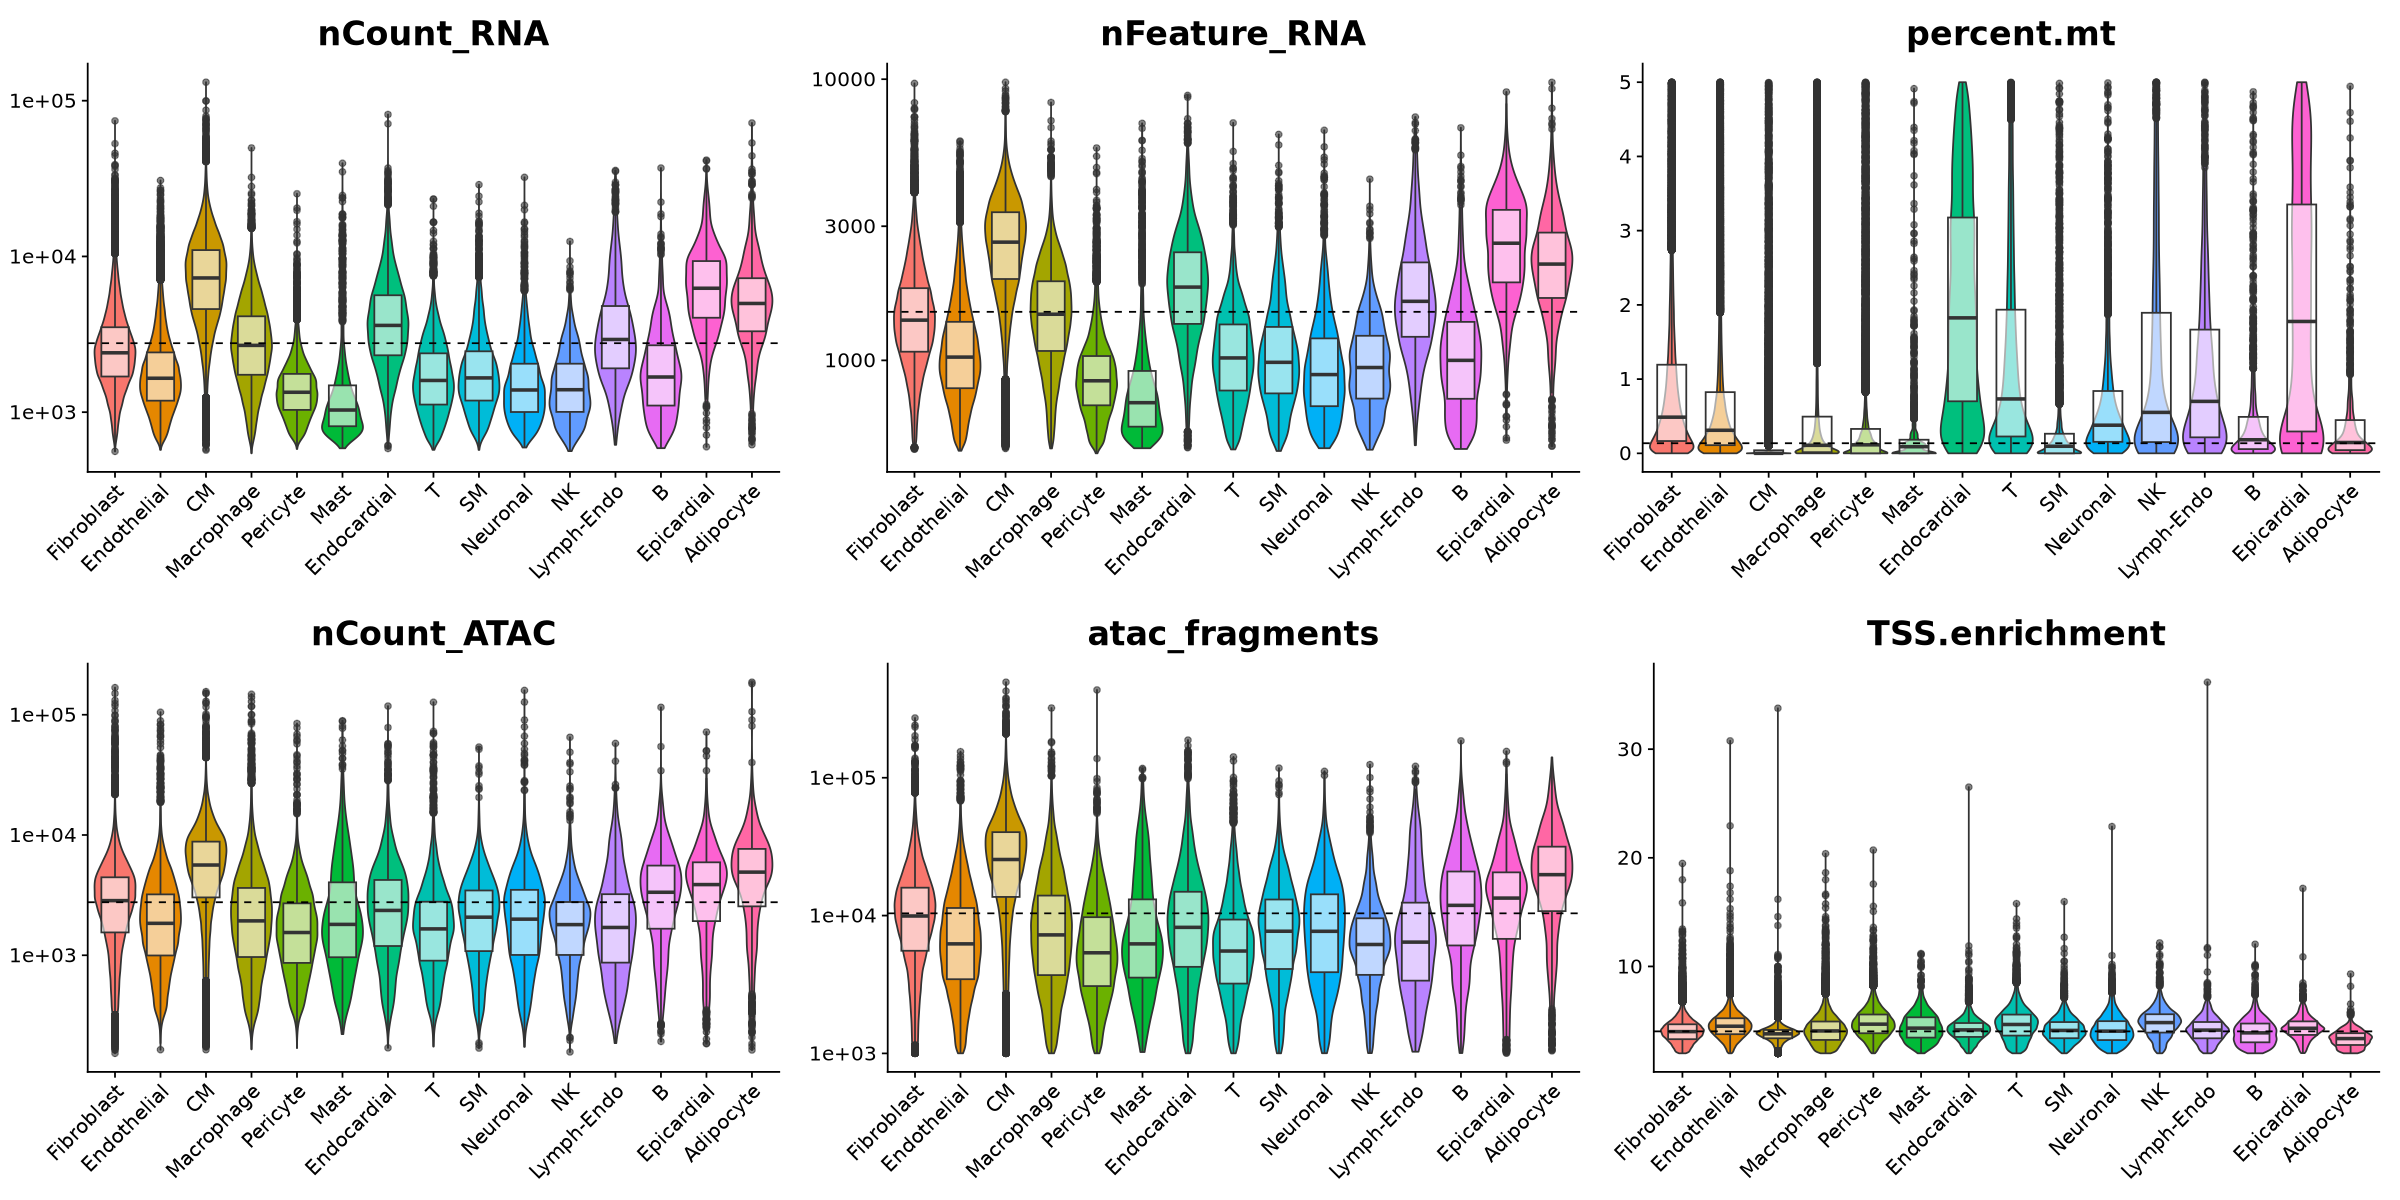

In [39]:
options(repr.plot.height = 10, repr.plot.width = 20)
ggarrange(p1, p2, p3,
          p4, p5, p6,
          ncol = 3, nrow = 2,
          common.legend = TRUE,legend="none")

In [40]:
ls()
rm(adata_list)
gc(reset = TRUE)

[1] "adata"                "adata_list"           "adata.bckp"          
 [4] "adata.check"          "annotations"          "assets.dir"          
 [7] "base.dir"             "cell_remove_combined" "cell.compartment"    
[10] "cell.markers"         "cellranger.links.dir" "cells"               
[13] "cells.comb"           "cells.condition"      "cells.covariant"     
[16] "cl"                   "cores"                "covariant"           
[19] "covariant2"           "exclusion"            "figure"              
[22] "g"                    "gg0"                  "gg1"                 
[25] "gg2"                  "gg3"                  "i"                   
[28] "j"                    "list_of_cells"        "log.file"            
[31] "meta_summary"         "out.dir"              "p1"                  
[34] "p2"                   "p3"                   "p4"                  
[37] "p5"                   "p6"                   "permutations"        
[40] "position"             "qc_data_combined"     "qc_data_plot"        
[43] "RAM.tresh"            "result_list"          "seq.info"            
[46] "Sil.QC"               "step1.dir"            "tresh"               
[49] "warnLevel"            "width"

used        (Mb)     gc trigger  (Mb)     max used    (Mb)    
Ncells    14322775    765.0    22800147   1217.7    14322775    765.0
Vcells 19791183047 150994.8 43971993812 335479.7 19791183047 150994.8

# Analysis and Harmonization

In [41]:
# RNA analysis
log_print("Starting RNA analysis")
DefaultAssay(adata) <- 'RNA'
log_print("  - SCTransform")
adata <- SCTransform(adata, verbose=FALSE)
gc(reset = TRUE)
log_print("  - RunPCA")
adata <- RunPCA(adata)
log_print("  - RunHarmony")
adata <- RunHarmony(adata, group.by.vars= c('library'), assay.use='SCT', reduction.save='harmony.rna')
log_print("  - RunUMAP")
adata <- RunUMAP(adata, dims=1:50, reduction='harmony.rna', reduction.name='umap.rna', reduction.key='rnaUMAP_')

[1] "Starting RNA analysis"
[1] "  - SCTransform"


used        (Mb)     gc trigger  (Mb)     max used    (Mb)    
Ncells    14399993    769.1    22800147   1217.7    14399993    769.1
Vcells 22207213011 169427.6 60787117204 463768.9 22207213011 169427.6

[1] "  - RunPCA"


PC_ 1 
Positive:  RYR2, TTN, FGF12, FHL2, CTNNA3, DMD, SORBS2, SLC8A1, MLIP, CACNA1C 
	   RBM20, SGCD, PDE3A, LINC02208, MYOM1, PALLD, TECRL, NEBL, AC092353.2, PDLIM5 
	   ANKRD1, CACNB2, CDH2, TTN-AS1, ERBB4, LDB3, CHRM2, FHOD3, TRDN, TRDN-AS1 
Negative:  F13A1, MRC1, DCN, RBPJ, FMN1, GSN, MGP, CDH19, CD163, LDB2 
	   CFD, NEGR1, MAN1A1, POSTN, ST6GALNAC3, CD163L1, C7, PLXDC2, CFH, PLA2G2A 
	   PKHD1L1, MECOM, MERTK, VCAN, RAB31, RBM47, NRG3, SLC9A9, KAZN, ELMO1 
PC_ 2 
Positive:  F13A1, MRC1, RBPJ, FMN1, CD163, CD163L1, MERTK, MAN1A1, RBM47, PDGFC 
	   MS4A6A, RAB31, CPM, FGF13, TBXAS1, MS4A4A, SMAP2, IQGAP2, SLCO2B1, SIPA1L1 
	   LYVE1, MS4A4E, KCNMA1, PTPRC, MSR1, AL162414.1, SAMSN1, TLR2, MS4A7, SLC9A9 
Negative:  DCN, CDH19, GSN, MGP, NEGR1, CFD, C7, CFH, PLA2G2A, LAMA2 
	   SCN7A, KAZN, APOD, IGFBP7, LUM, POSTN, ACSM3, FN1, BICC1, SPARCL1 
	   FBN1, EBF1, FBLN1, CCN2, COL3A1, ABCA10, COL1A2, KCNT2, NOX4, LDB2 
PC_ 3 
Positive:  DCN, CDH19, NEGR1, CFD, GSN, F13A1, MGP, LAMA2, KAZ

[1] "  - RunHarmony"


Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony converged after 4 iterations



[1] "  - RunUMAP"


19:31:41 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

19:31:41 Read 346173 rows and found 50 numeric columns

19:31:41 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

19:31:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:33:58 Writing NN index file to temp file /nfs/lab/Luca/TMP/Rtmpr02YSD/file23e4a6540c94cb

19:34:01 Searching Annoy index using 4 threads, search_k = 3000

19:35:43 Annoy recall = 97.83%

19:35:46 Commencing smooth kNN distance calibration using 4 threads
 with target n_neighbors = 30

19:36:12 Initializing from nor

In [42]:
# ATAC analysis
log_print("Starting ATAC analysis")
DefaultAssay(adata) <- 'ATAC'
log_print("  - RunTFIDF")
adata <- RunTFIDF(adata)
adata <- FindTopFeatures(adata, min.cutoff='q0', verbose=FALSE)
log_print("  - RunSVD")
adata <- RunSVD(adata)
log_print("  - RunHarmony")
hm_atac <- HarmonyMatrix(Embeddings(adata, reduction='lsi'), 
                         vars_use = c('library'), meta_data = adata@meta.data, 
                         do_pca=FALSE)
adata[['harmony.atac']] <- CreateDimReducObject(embeddings=hm_atac, key='atac_', assay='ATAC')
log_print("  - RunUMAP")
adata <- RunUMAP(adata, dims=2:50, reduction='harmony.atac', reduction.name='umap.atac', reduction.key='atacUMAP_')

[1] "Starting ATAC analysis"
[1] "  - RunTFIDF"


Performing TF-IDF normalization



[1] "  - RunSVD"


Running SVD

Scaling cell embeddings



[1] "  - RunHarmony"


Transposing data matrix

Initializing state using k-means centroids initialization

Harmony 1/10

Harmony 2/10

Harmony converged after 2 iterations



[1] "  - RunUMAP"


20:38:29 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

20:38:29 Read 346173 rows and found 49 numeric columns

20:38:29 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

20:38:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:39:22 Writing NN index file to temp file /nfs/lab/Luca/TMP/Rtmpr02YSD/file23e4a636031f88

20:39:36 Searching Annoy index using 4 threads, search_k = 3000

20:41:03 Annoy recall = 100%

20:41:06 Commencing smooth kNN distance calibration using 4 threads
 with target n_neighbors = 30

20:41:29 Initializing from norma

In [43]:
# Combining Modalities
log_print("Combining Modalities")
log_print("  - FindMultiModalNeighbors")
adata <- FindMultiModalNeighbors(adata, reduction.list=list('harmony.rna', 'harmony.atac'), dims.list=list(1:50, 2:50))
log_print("  - RunUMAP")
adata <- RunUMAP(adata, nn.name='weighted.nn', reduction.name='umap.wnn', reduction.key='wnnUMAP_')
log_print("  - FindClusters")
adata <- FindClusters(adata, graph.name='wsnn', algorithm=4,  resolution = 0.6, verbose=FALSE, method = 'igraph')

adata$log_nCount_ATAC=log(adata$nCount_ATAC)
adata$log_nCount_SCT=log(adata$nCount_SCT)
adata$log_nFeature_ATAC=log(adata$nFeature_ATAC)
adata$log_nFeature_SCT=log(adata$nFeature_SCT)

[1] "Combining Modalities"
[1] "  - FindMultiModalNeighbors"


Calculating cell-specific modality weights

Finding 20 nearest neighbors for each modality.

Calculating kernel bandwidths

Finding multimodal neighbors

Constructing multimodal KNN graph

Constructing multimodal SNN graph



[1] "  - RunUMAP"


21:06:59 UMAP embedding parameters a = 0.9922 b = 1.112

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by 'BiocGenerics'

21:07:05 Commencing smooth kNN distance calibration using 4 threads
 with target n_neighbors = 20

21:07:05 3 smooth knn distance failures

21:07:22 Initializing from normalized Laplacian + noise (using RSpectra)

21:09:33 Commencing optimization for 200 epochs, with 11480680 positive edges

21:13:33 Optimization finished



[1] "  - FindClusters"


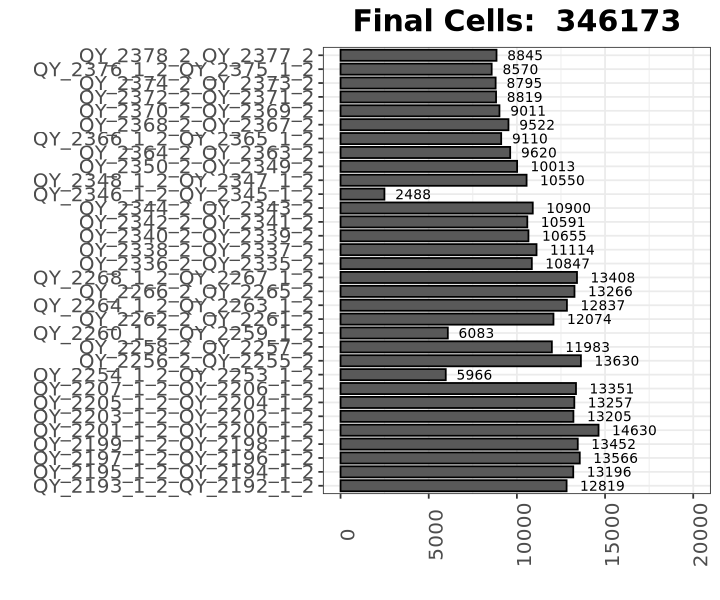

In [44]:
cell.sample = as.data.frame(table(adata$library))
colnames(cell.sample)[1] = "sample.ID"

options(repr.plot.width=6, repr.plot.height=5)

width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(cell.sample, aes(x= sample.ID, y = Freq, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Final Cells: ", length(colnames(adata[["RNA"]])))) +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            ylim(0, 20000)+
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            geom_text(hjust = -0.3, size = 2.9, position = position_dodge(width = width))+
            coord_flip()
gg1

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



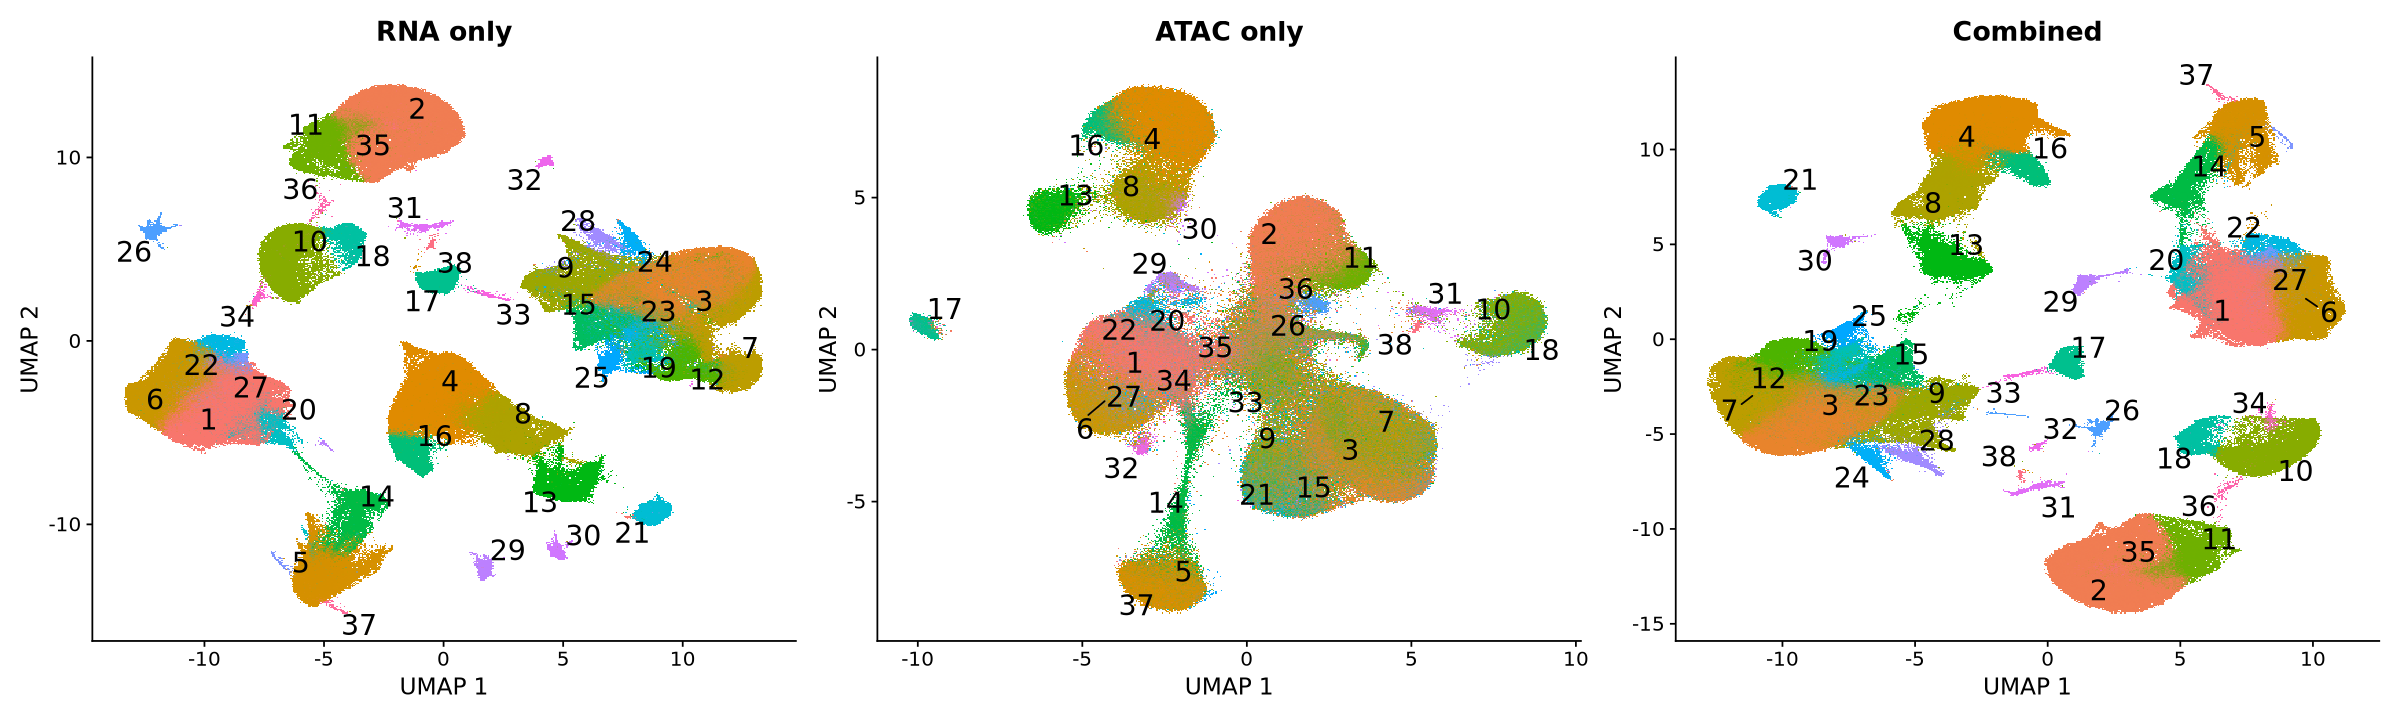

In [45]:
options(repr.plot.width=20, repr.plot.height=6)
p1 <- DimPlot(adata, reduction='umap.rna', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('RNA')
p1 <- p1 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('RNA only')
p2 <- DimPlot(adata, reduction='umap.atac', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('ATAC')
p2 <- p2 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('ATAC only')
p3 <- DimPlot(adata, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p1 + p2 + p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))

In [46]:
cell.cluster = as.data.frame(table(adata$chamber, adata$seurat_clusters))
colnames(cell.cluster)[1] = "chamber"
colnames(cell.cluster)[2] = "seurat_clusters"
cell.cluster = dplyr::filter(cell.cluster, Freq != 0)

In [53]:
table(adata$seurat_clusters)


    1     2     3     4     5     6     7     8     9    10    11    12    13 
38784 38459 36978 32340 21948 21071 20497 15545 15038 15024 11287  9446  9440 
   14    15    16    17    18    19    20    21    22    23    24    25    26 
 7463  6025  4505  4146  3757  3638  3424  3154  3055  2661  2263  2195  2178 
   27    28    29    30    31    32    33    34    35    36    37    38 
 2128  2097  1707  1636  1542  1198   437   350   207   207   173   170 

In [47]:
width = 0.8
gg1 = ggplot(cell.cluster, aes(x= seurat_clusters, y = Freq, fill = chamber, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell #: ", length(colnames(adata[["RNA"]])))) +
            geom_bar(stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()

gg2 = ggplot(cell.cluster, aes(x= seurat_clusters, y = Freq, fill = chamber, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                  axis.text.y = element_blank(),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()

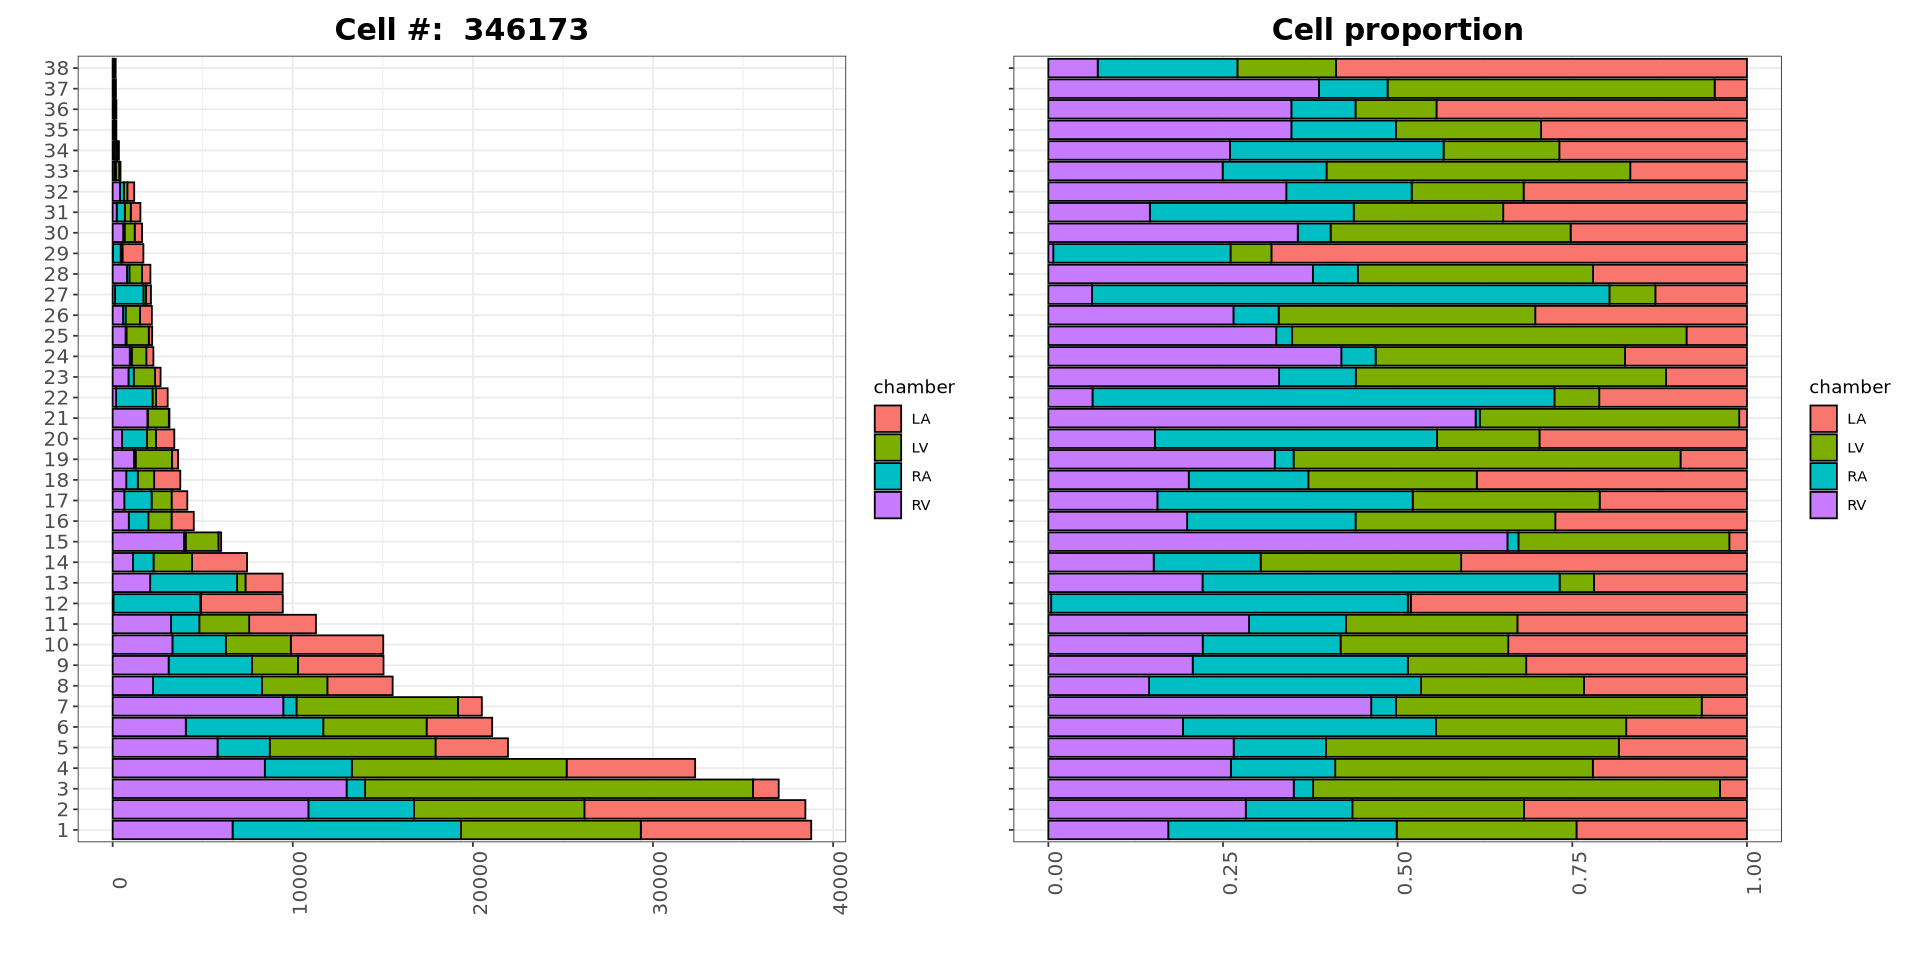

In [48]:
options(repr.plot.width=16, repr.plot.height=8)
gg1 + gg2 & theme(plot.title=element_text(hjust=0.5))

# Celltype assignment

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



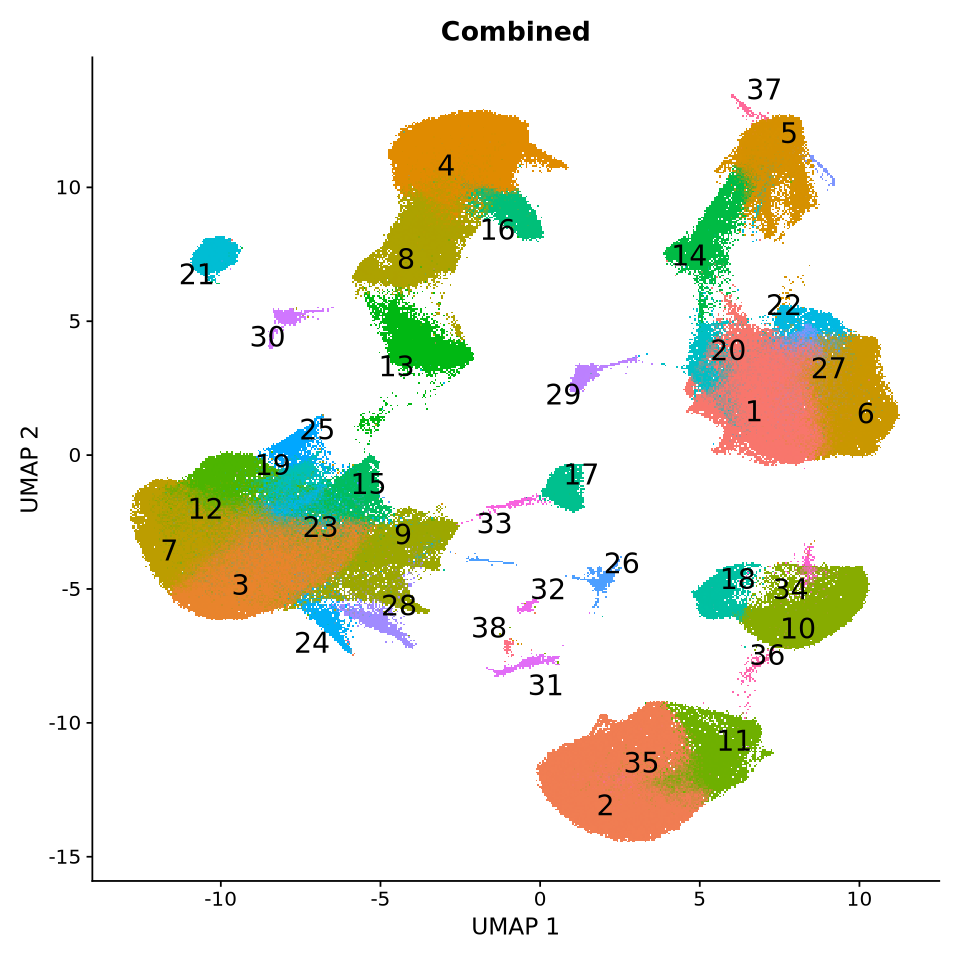

In [21]:
options(repr.plot.width=8, repr.plot.height=8)
p3 <- DimPlot(adata, reduction='umap.wnn', group.by='seurat_clusters', label=TRUE, label.size=6, repel=TRUE) + ggtitle('WNN')
p3 <- p3 + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined')
p3 & NoLegend() & theme(plot.title=element_text(hjust=0.5))

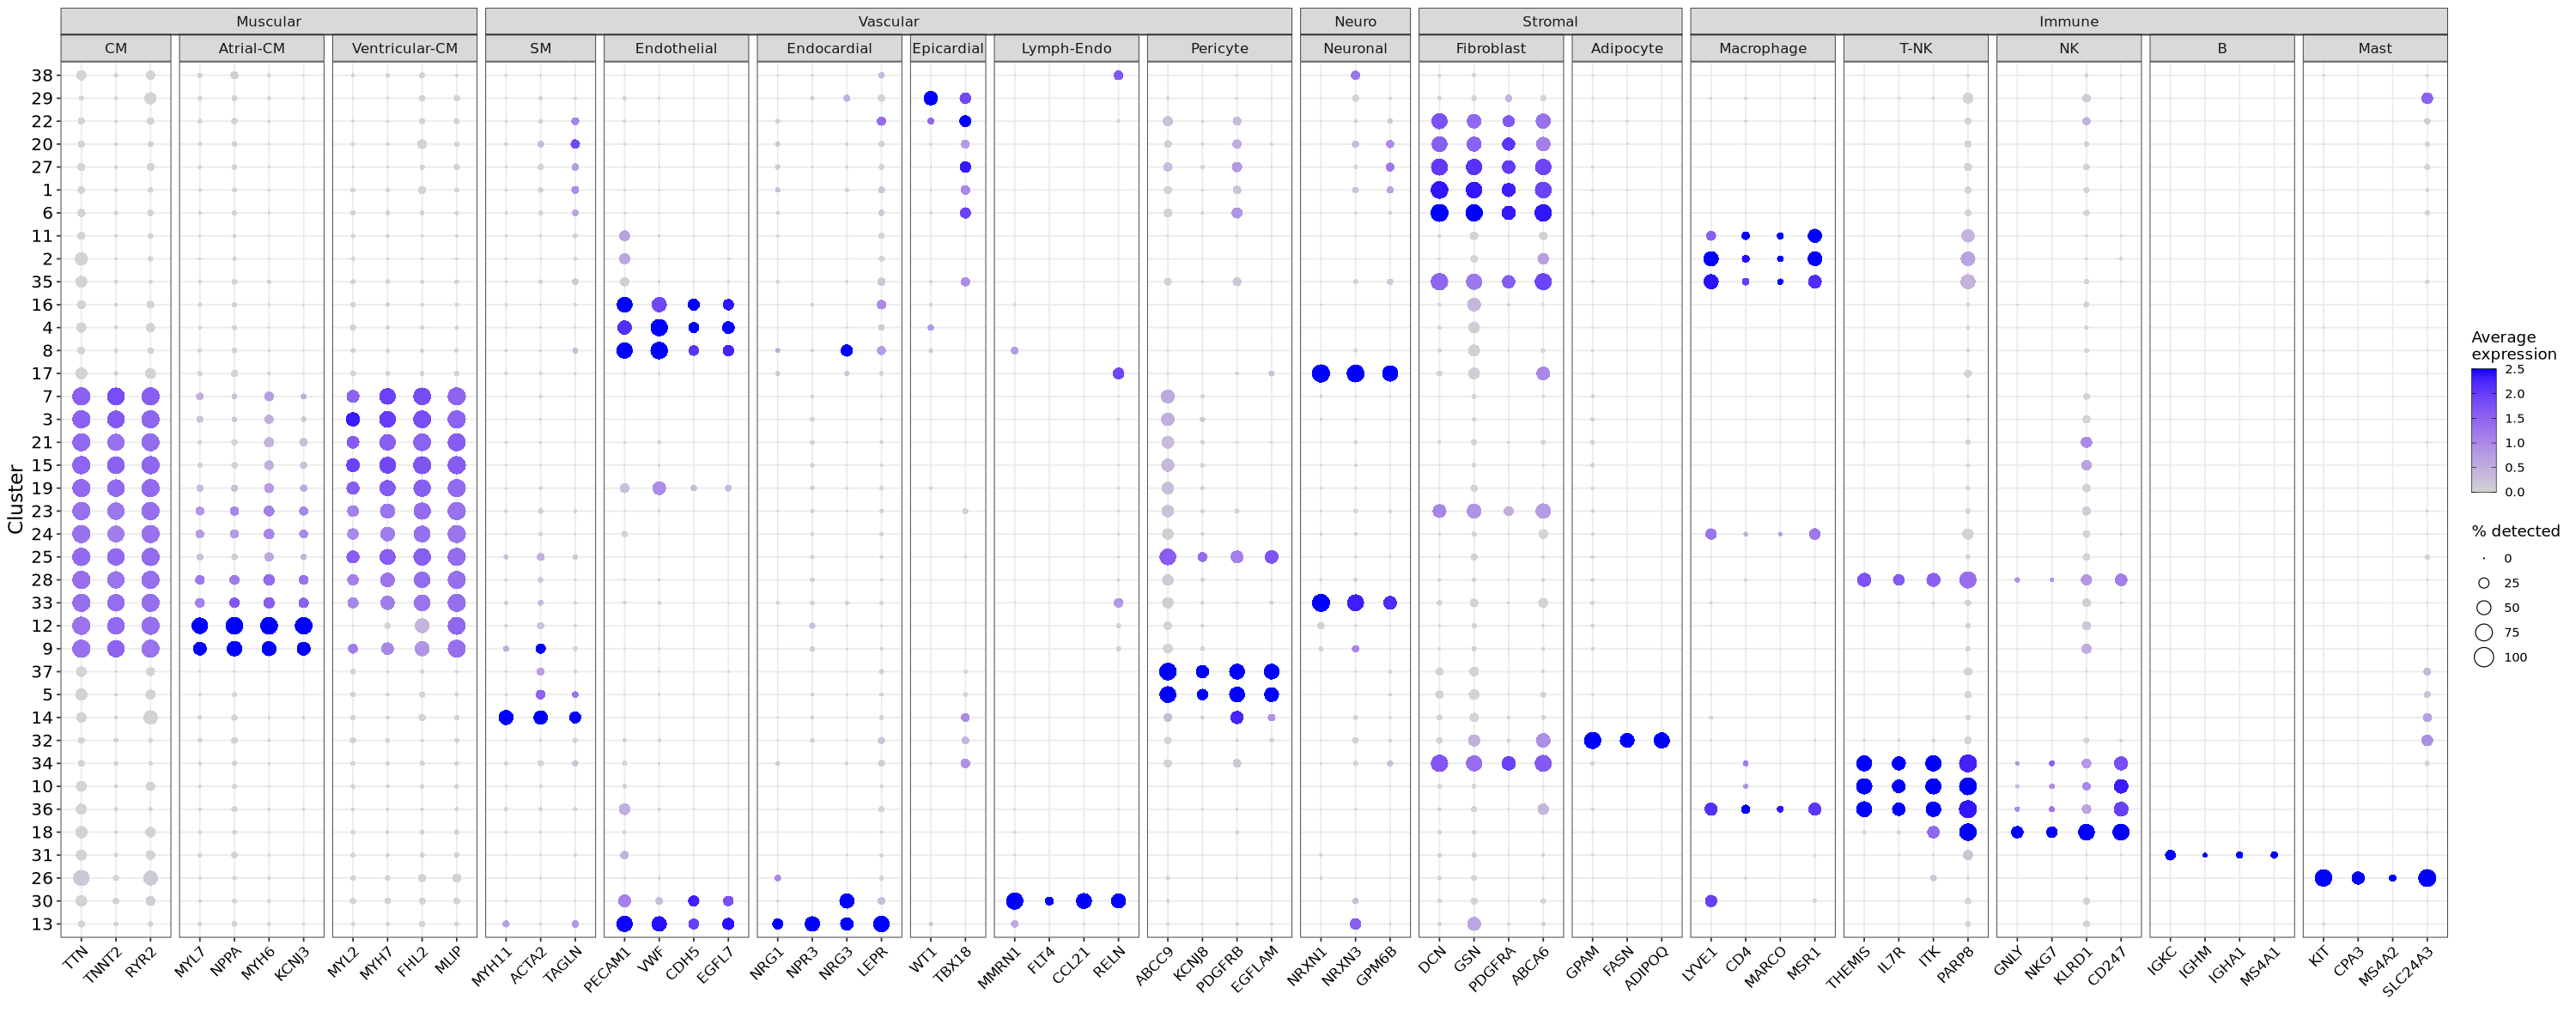

In [50]:
g = DotPlot(adata, assay='SCT', features=cell.markers$marker, cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=25, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
    figure

In [51]:
levels(cell.markers$CellType)

[1] "CM"             "Atrial-CM"      "Ventricular-CM" "SM"            
 [5] "Endothelial"    "Endocardial"    "Epicardial"     "Lymph-Endo"    
 [9] "Pericyte"       "Neuronal"       "Fibroblast"     "Adipocyte"     
[13] "Macrophage"     "T-NK"           "NK"             "B"             
[17] "Mast"

In [54]:
# list cluster numbers as they appear in the dotplot
# list cluster numbers as they appear in the dotplot
clusters = rev(levels(g$data$id))
clusters

# visually determine celltypes
celltypes = c("B", 'Epicardial', 
             'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 'Fibroblast', 
              'Macrophage', 'Macrophage', 'Macrophage',
             'Endothelial', 'Endothelial', 'Endothelial','Neuronal', 
              "CM", "CM", "CM", "CM", "CM", "CM", "CM", "CM", "CM", "CM", "CM", "CM",
             'Pericyte', 'Pericyte', "SM",
              'Adipocyte', "T", "T", "T", "NK", "B", 'Mast',
              'Lymph-Endo', 'Endocardial'
             )

length(clusters)
length(celltypes)

clusters.celltypes = data.frame(seurat_clusters = clusters,
                               celltypes = celltypes)

[1] "38" "29" "22" "20" "27" "1"  "6"  "11" "2"  "35" "16" "4"  "8"  "17" "7" 
[16] "3"  "21" "15" "19" "23" "24" "25" "28" "33" "12" "9"  "37" "5"  "14" "32"
[31] "34" "10" "36" "18" "31" "26" "30" "13"

[1] 38

[1] 38

In [55]:
# Assign celltypes
adata <- SetIdent(adata, value = adata$seurat_clusters)
levels(adata)
adata$celltypes <- clusters.celltypes$celltypes[match(adata$seurat_clusters, clusters.celltypes$seurat_clusters)]
adata <- SetIdent(adata, value = adata$celltypes)
levels(adata)

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26" "27" "28" "29" "30"
[31] "31" "32" "33" "34" "35" "36" "37" "38"

[1] "Fibroblast"  "Endothelial" "CM"          "Macrophage"  "Pericyte"   
 [6] "Mast"        "Endocardial" "T"           "SM"          "B"          
[11] "Neuronal"    "NK"          "Lymph-Endo"  "Epicardial"  "Adipocyte"

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



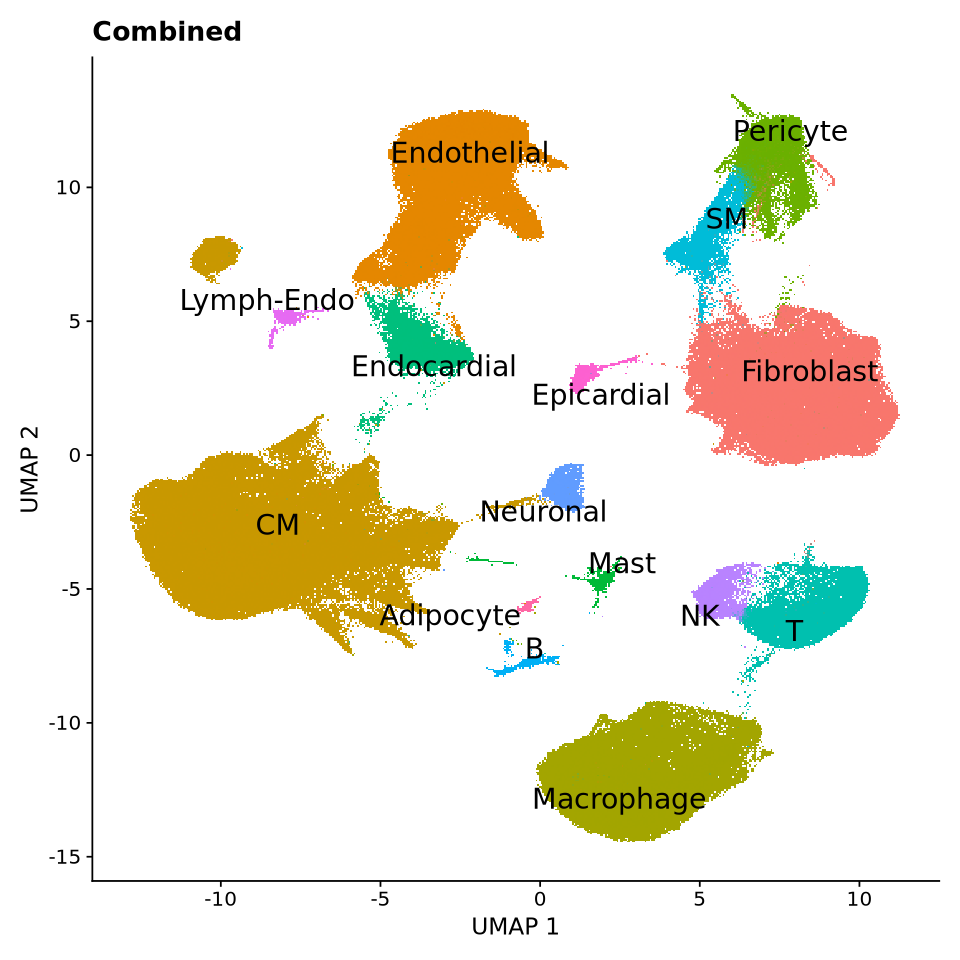

In [56]:
options(repr.plot.width=8, repr.plot.height=8)
DimPlot(adata, reduction='umap.wnn', label=TRUE, label.size=6, repel=TRUE) +
ggtitle('WNN') + xlab('UMAP 1') + ylab('UMAP 2') + ggtitle('Combined') & NoLegend()

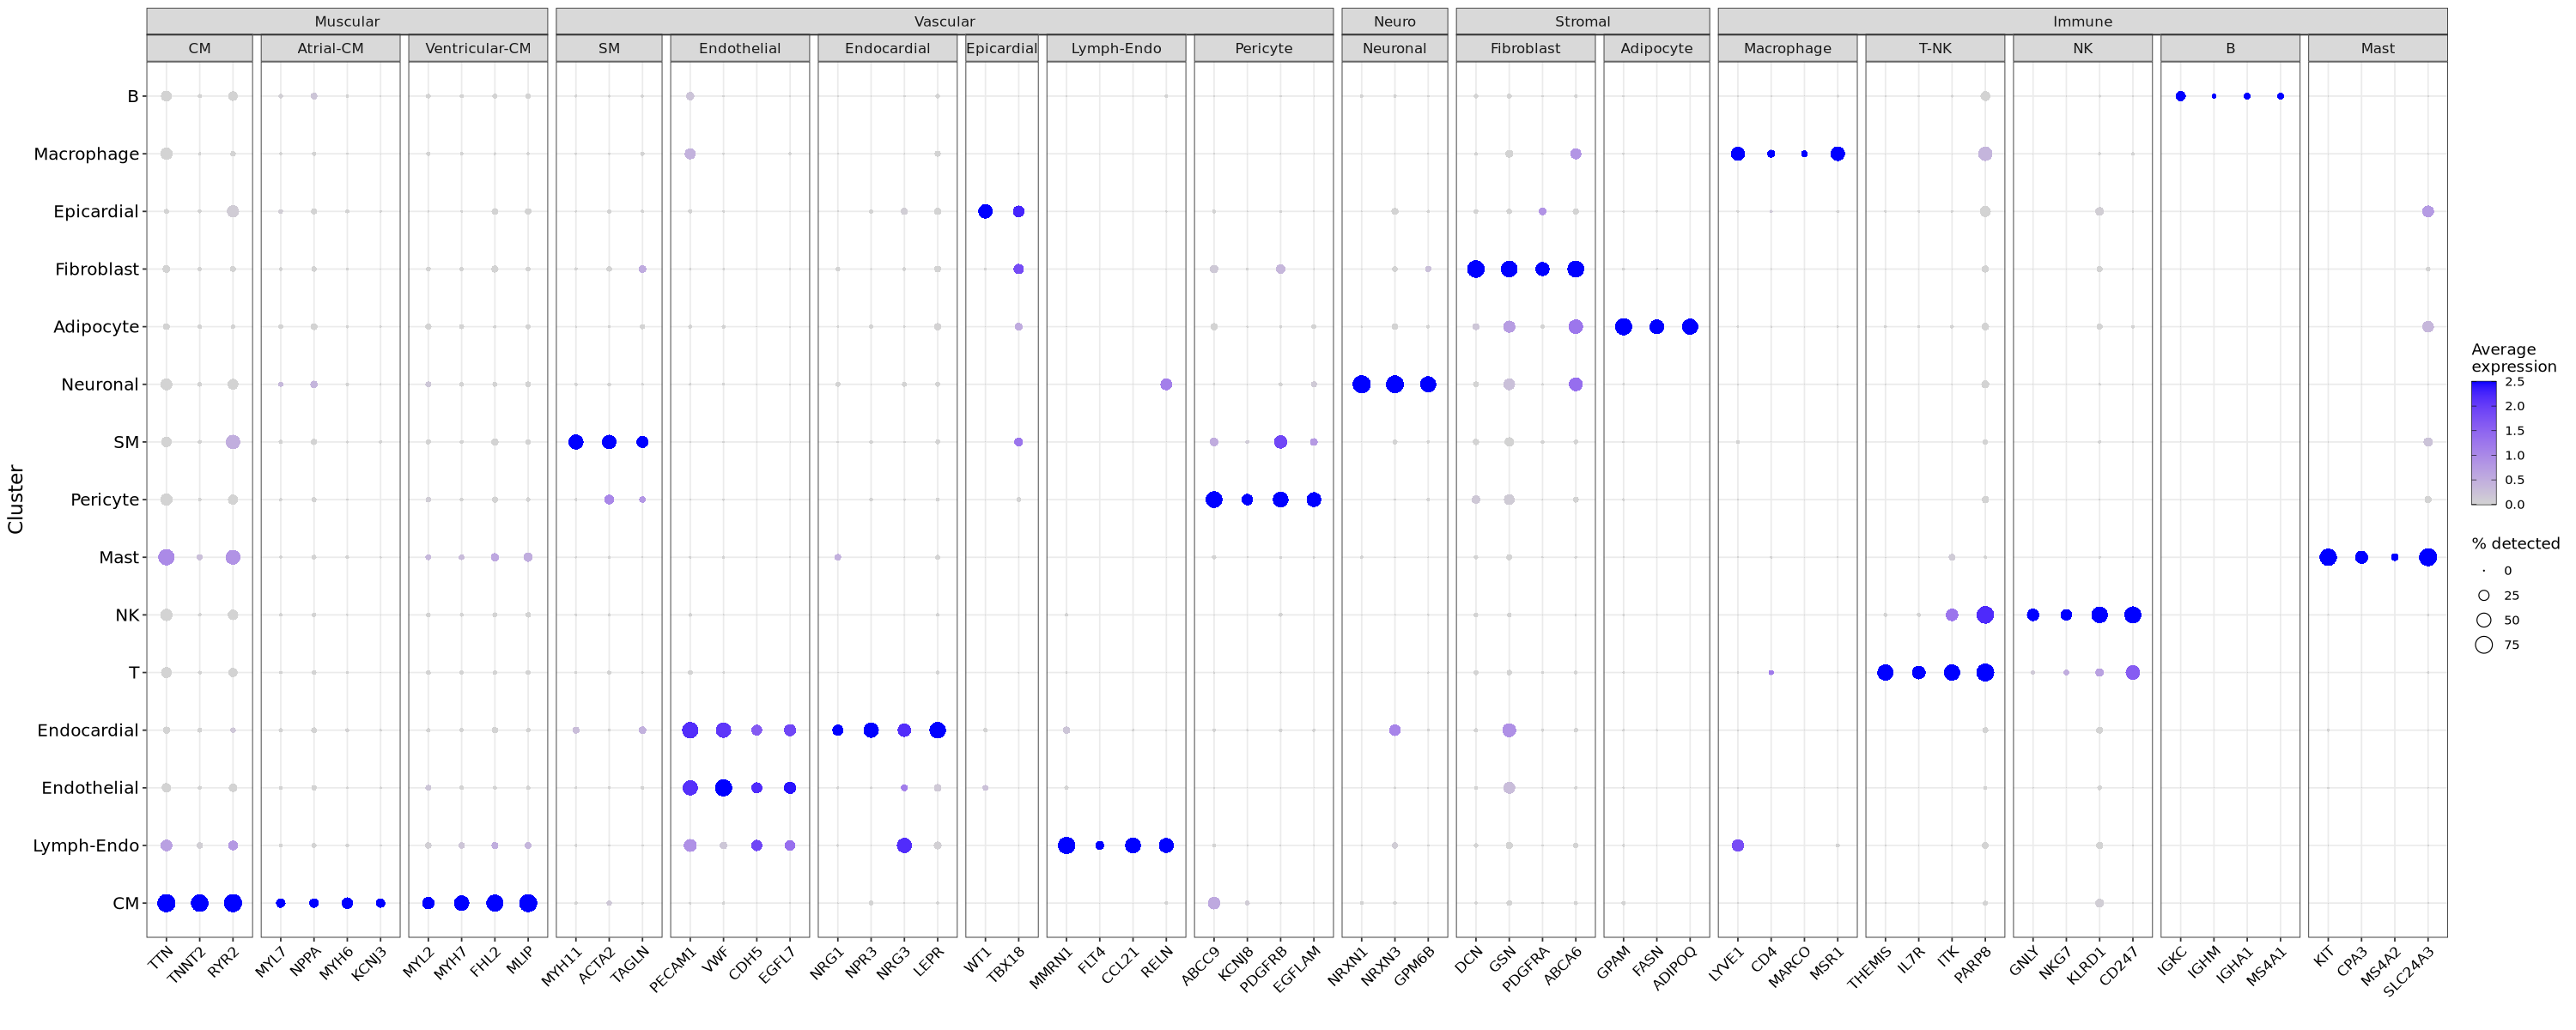

In [57]:
g = DotPlot(adata, assay='SCT', features=cell.markers$marker, cluster.idents=TRUE, col.min=0) +
        theme(axis.text.x=element_text(angle=45, hjust=1)) + xlab('') + ylab('')
    meta_summary = g$data
    colnames(meta_summary)[3] = "marker"
    meta_summary = merge(meta_summary, cell.markers, by = "marker")

    options(repr.plot.width=25, repr.plot.height=10)
    figure <- ggplot(meta_summary, aes(x = marker, y = id)) +
      geom_point(aes(size = pct.exp, fill = avg.exp.scaled, stroke=NA),
                 shape = 21) +
      scale_size("% detected", range = c(0, 6)) +
      scale_fill_gradient(low = "lightgray", high = "blue",
                           guide = guide_colorbar(nbin = 200,
                                                  ticks.colour = "black", frame.colour = "black"),
                           name = "Average\nexpression") +
      ylab("Cluster") + xlab("") +
      theme_bw() +
      theme(axis.text = element_text(size = 100),
            axis.text.x = element_text(size = 10, angle = 45, hjust = 1, color = "black"),
            strip.text.x = element_text(size = 10),
            axis.text.y = element_text(size = 12, color = "black"),
            axis.title = element_text(size = 14)) +
      facet_nested(cols = vars(Compartment, CellType), scales = "free", space = "free")
    figure

In [ ]:
### Write  RDS
log_print("Saving RDS")
file = paste(step1.dir, "LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.rds", sep = "")
saveRDS(adata, file = file)
log_print("RDS - Saved")

[1] "Saving RDS"


# Celltype QC

In [11]:
file = paste(step1.dir, "LV_RV_LA_RA.multiome.mrg.filt.MTless.silQC.rds", sep = "")
adata = readRDS(file)

In [12]:
cell.sample = as.data.frame(table(adata$celltypes, adata$donor, adata$chamber, adata$condition))
colnames(cell.sample)[1] = "celltypes"
colnames(cell.sample)[2] = "donor"
colnames(cell.sample)[3] = "chamber"
colnames(cell.sample)[4] = "condition"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

cell.sample$chamber = factor(cell.sample$chamber, levels = c("LA", "RA", "LV", "RV"))

In [13]:
width = 0.8
gg1 = ggplot(cell.sample, aes(x= celltypes, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell #: ", length(colnames(adata[["RNA"]])))) +
            geom_bar(stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip() +
            facet_wrap(~ chamber, scales = "fixed", ncol = 1)

gg2 = ggplot(cell.sample, aes(x= celltypes, y = Freq, fill = condition, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Cell proportion")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5),
                  axis.text.y = element_blank())+
            coord_flip() +
            facet_wrap(~ chamber, scales = "fixed", ncol = 1)

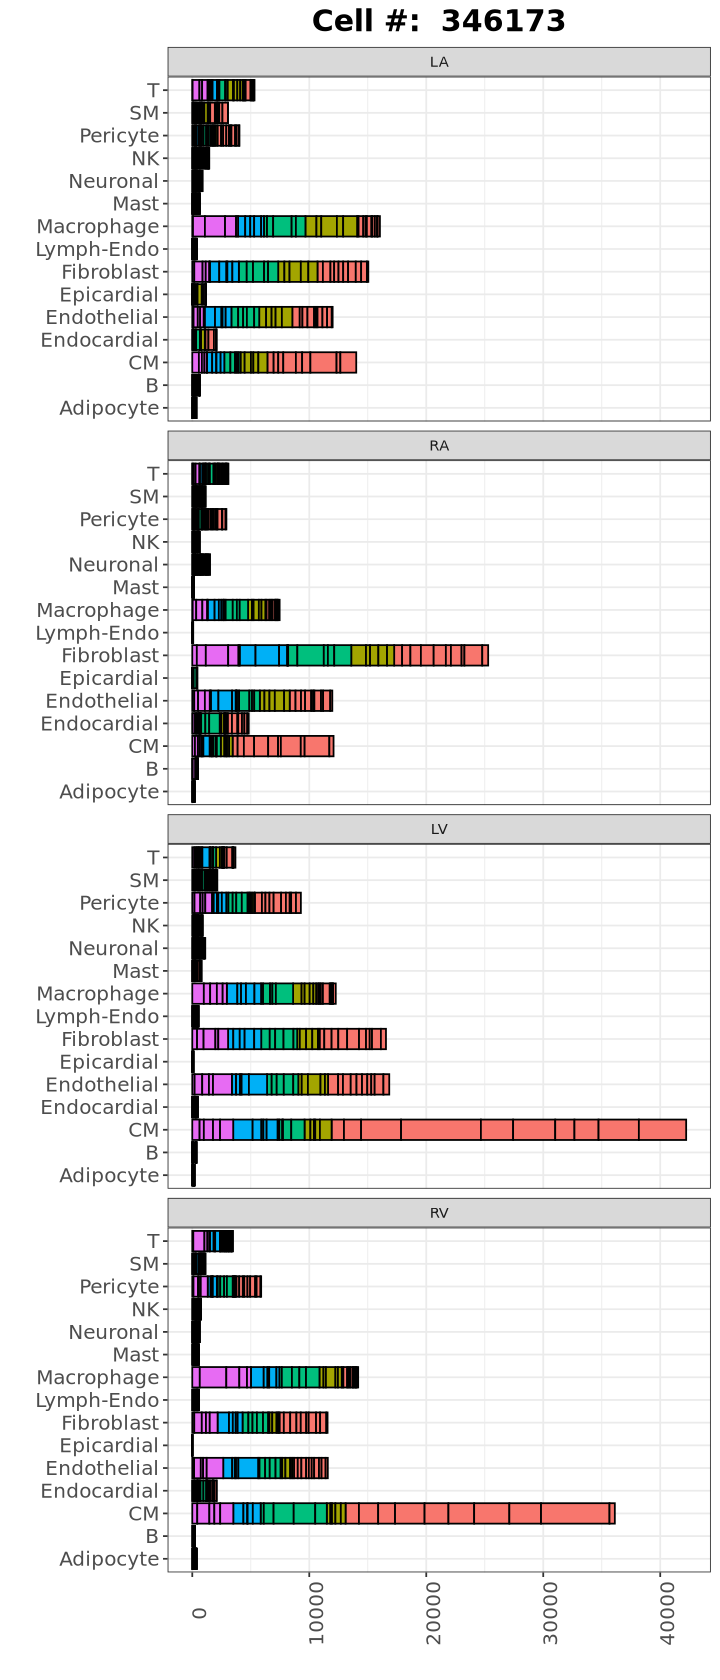

In [14]:
options(repr.plot.width=6, repr.plot.height=14)
gg1 & NoLegend()

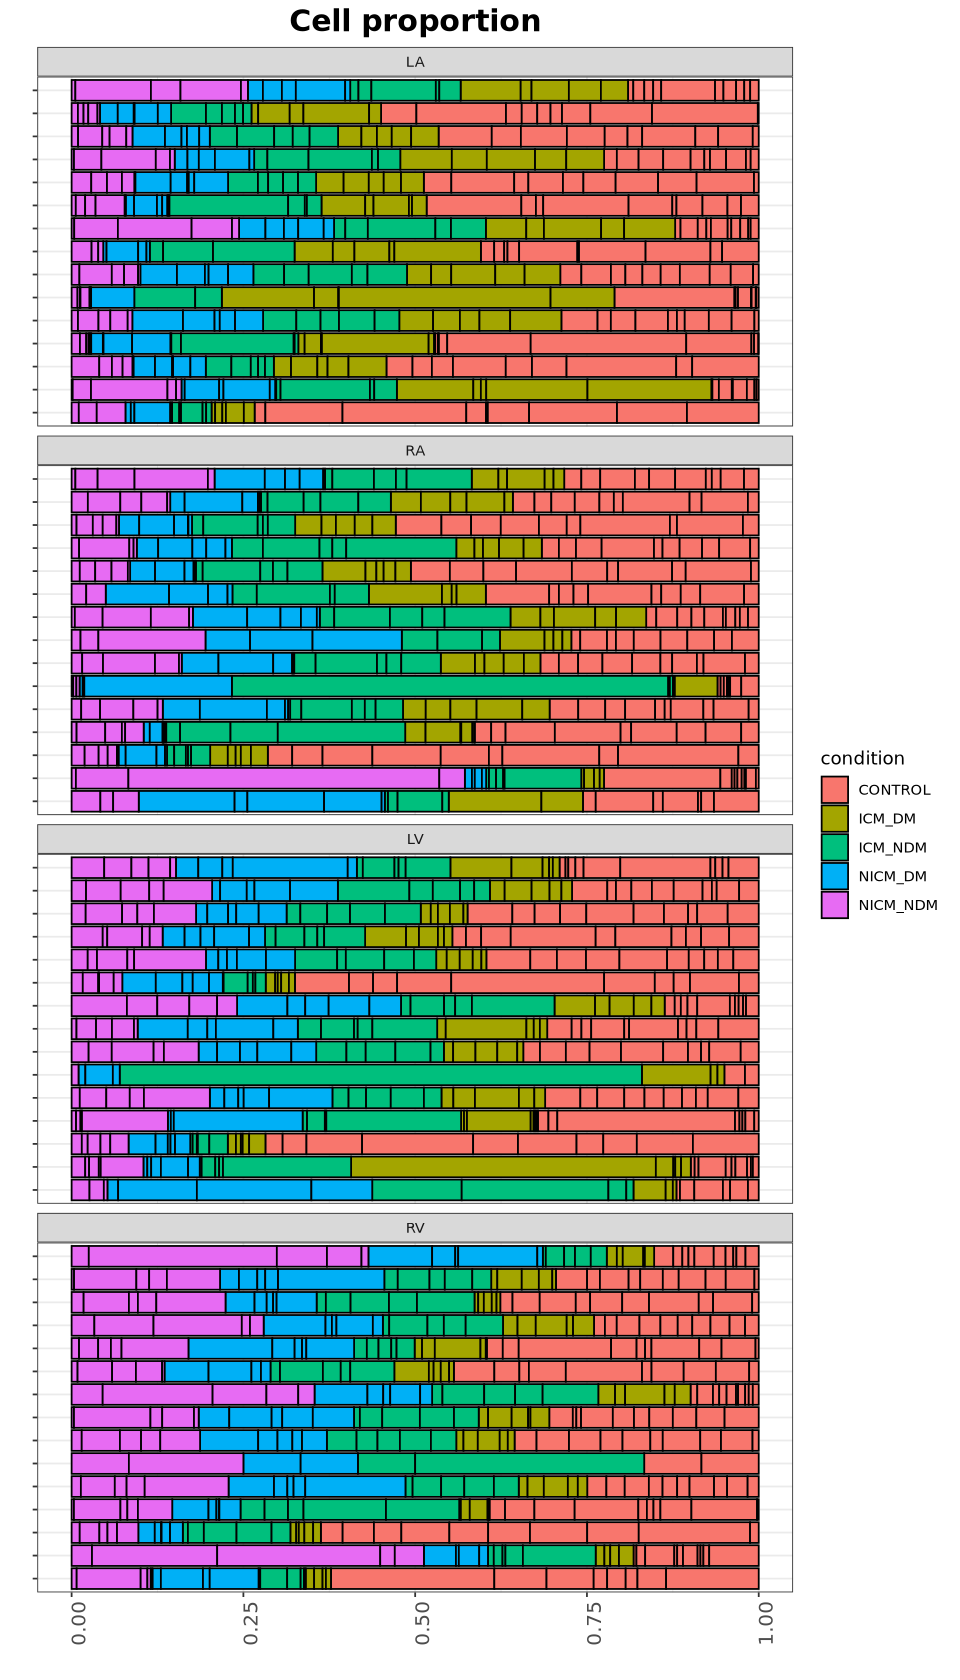

In [15]:
options(repr.plot.width=8, repr.plot.height=14)
gg2

In [29]:
cell.cluster = as.data.frame(table(adata$celltypes))
colnames(cell.cluster)[1] = "celltype"
width = 0.8
position = position_dodge(width = width)
gg1 = ggplot(cell.cluster, aes(x= reorder(celltype, +Freq), y = Freq, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Final Cells: ", length(colnames(adata[["RNA"]])))) +
            geom_bar(stat="identity", 
                     position = position, width = width,
                     colour="black") +
            ylim(0, 150000)+
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            geom_text(hjust = -0.3, size = 2.9, position = position_dodge(width = width))+
            coord_flip()

# numbers per condition
cell.sample = as.data.frame(table(adata$celltypes, adata$chamber))
colnames(cell.sample)[1] = "celltype"
colnames(cell.sample)[2] = "chamber"
cell.sample = dplyr::filter(cell.sample, Freq != 0)

gg2 = ggplot(cell.sample, aes(x= reorder(celltype, +Freq), y = Freq, fill = chamber, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Breakdown by chamber")) +
            geom_bar(stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),
                  plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip() & NoLegend()

gg3 = ggplot(cell.sample, aes(x= reorder(celltype, +Freq), y = Freq, fill = chamber, label = Freq)) + 
            theme_bw () +
            labs(y= "", x = "", title = paste("Proportion by chamber")) +
            geom_bar(position = position_fill(reverse = FALSE), stat = 'identity', color = 'black', size = 0.5) +
            theme(axis.text = element_text(size = 12), axis.title = element_text(size = 12, face = "bold"),
                  axis.text.x = element_text(angle = 90),,
                             plot.title = element_text(size = 18, face = "bold", , hjust = 0.5))+
            coord_flip()

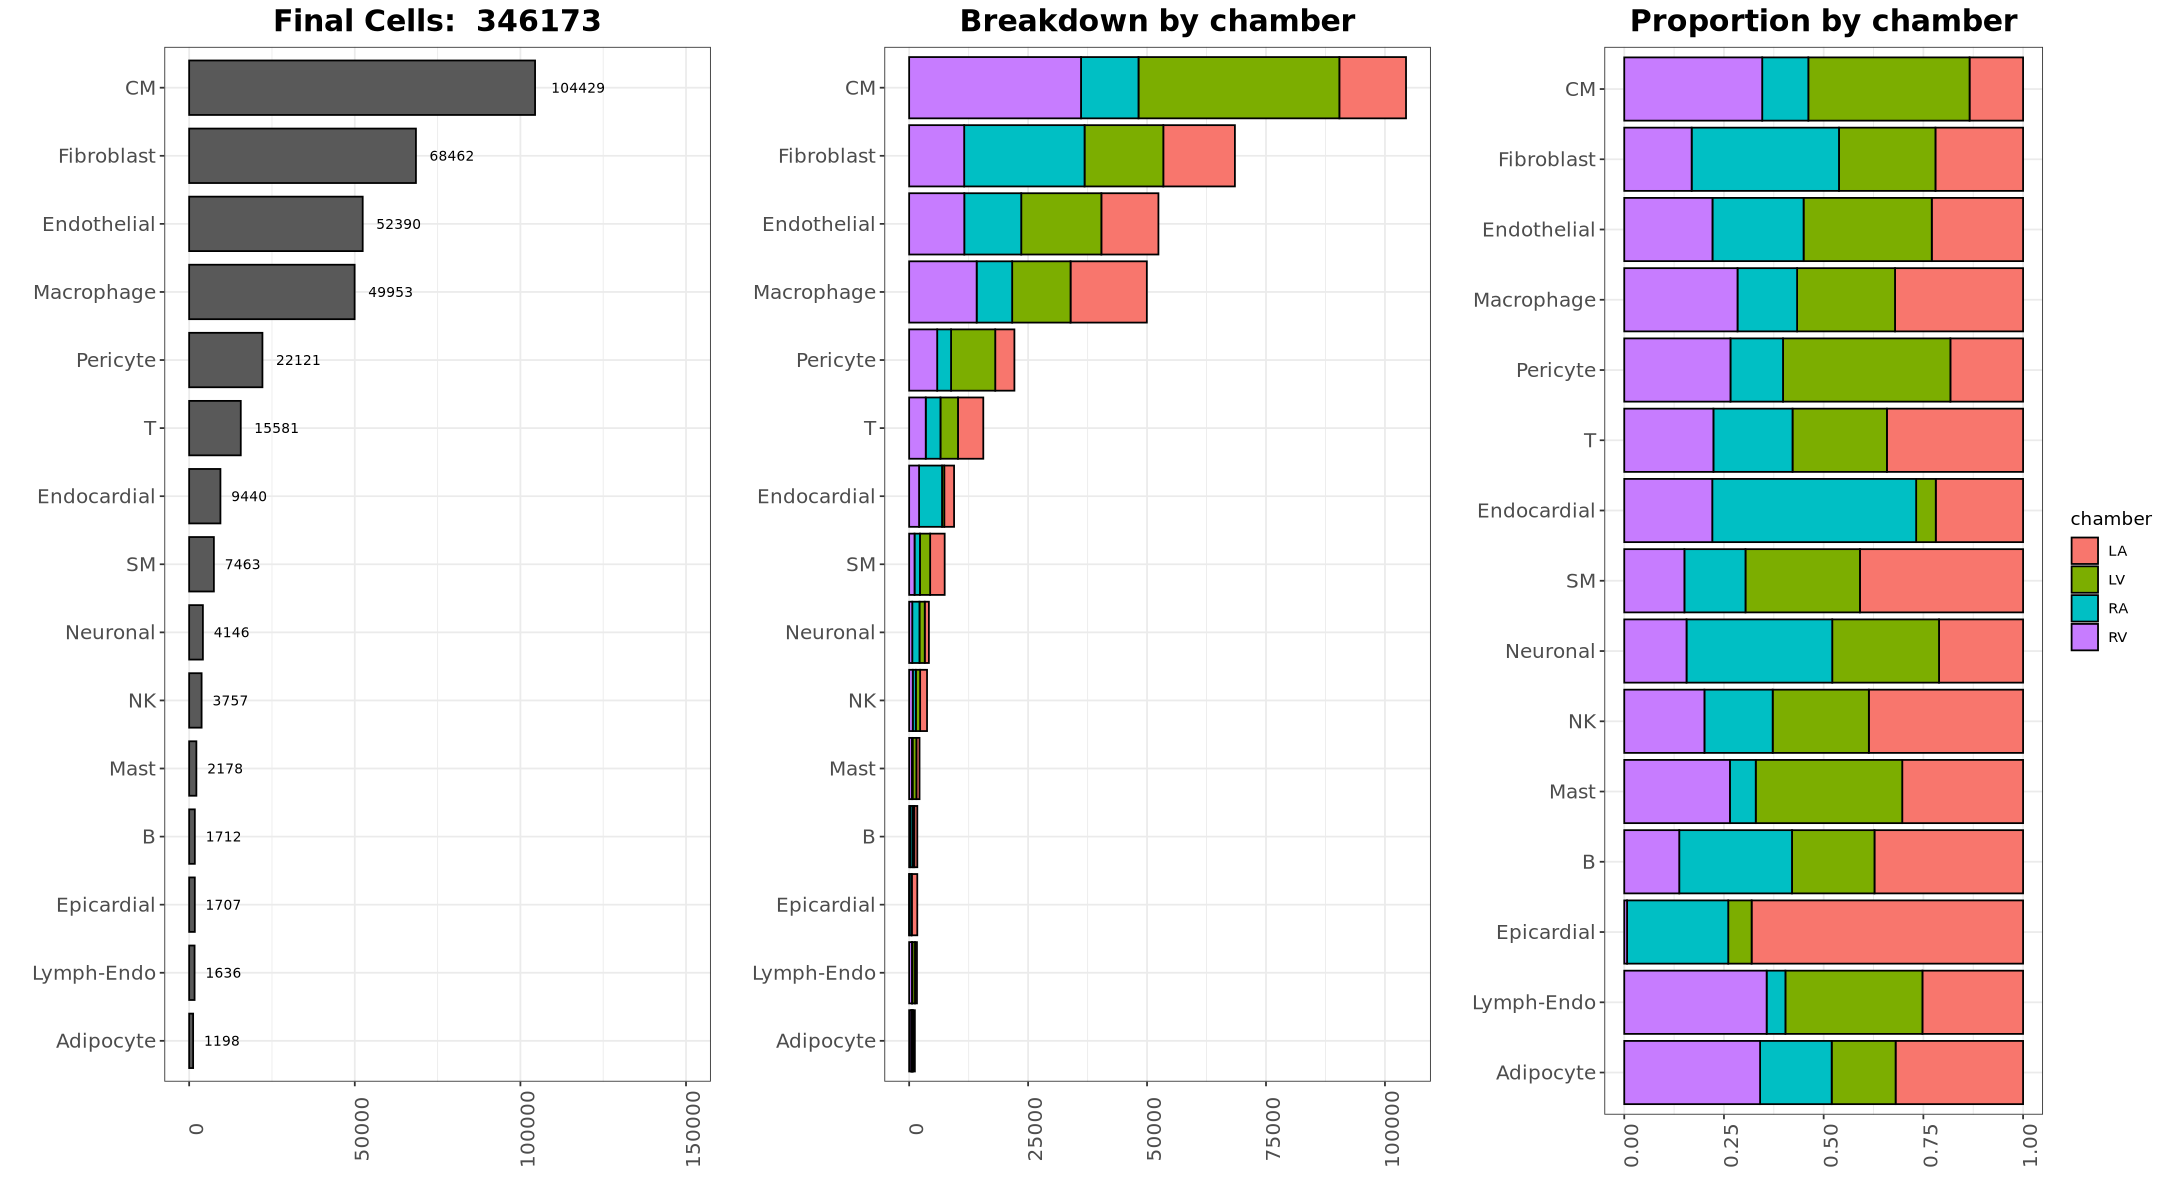

In [31]:
options(repr.plot.height = 10, repr.plot.width = 18)
ggarrange(gg1, gg2, gg3, ncol = 3, nrow = 1)

In [18]:
# Create a combined metadata column to summarize clusters and celltypes
adata$cluster_celltype = paste0(adata$celltypes, "--", adata$seurat_clusters)

In [19]:
# RNA plots
    p1 <- VlnPlot(adata, features='nFeature_RNA', group.by = 'cluster_celltype', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6, pt.size=0) + geom_hline(yintercept=median(adata$nFeature_RNA, na.rm = TRUE), linetype='dashed', lw=2) + 
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())
    p2 <- VlnPlot(adata, features='percent.mt', group.by = 'cluster_celltype', pt.size=0) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$percent.mt, na.rm = TRUE), linetype='dashed')+
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())

# ATAC plots
    p3 <- VlnPlot(adata, features='atac_fragments', group.by = 'cluster_celltype', pt.size=0, log=TRUE) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$atac_fragments, na.rm = TRUE), linetype='dashed', lw=2)+
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())
    p4 <- VlnPlot(adata, features='TSS.enrichment', group.by = 'cluster_celltype', pt.size=0) + geom_boxplot(width=.6, fill='white', alpha=.6) + geom_hline(yintercept=median(adata$TSS.enrichment, na.rm = TRUE), linetype='dashed', lw=2)+
    theme(plot.title = element_text(size = 20), axis.text = element_text(size=12),
          axis.title = element_blank())

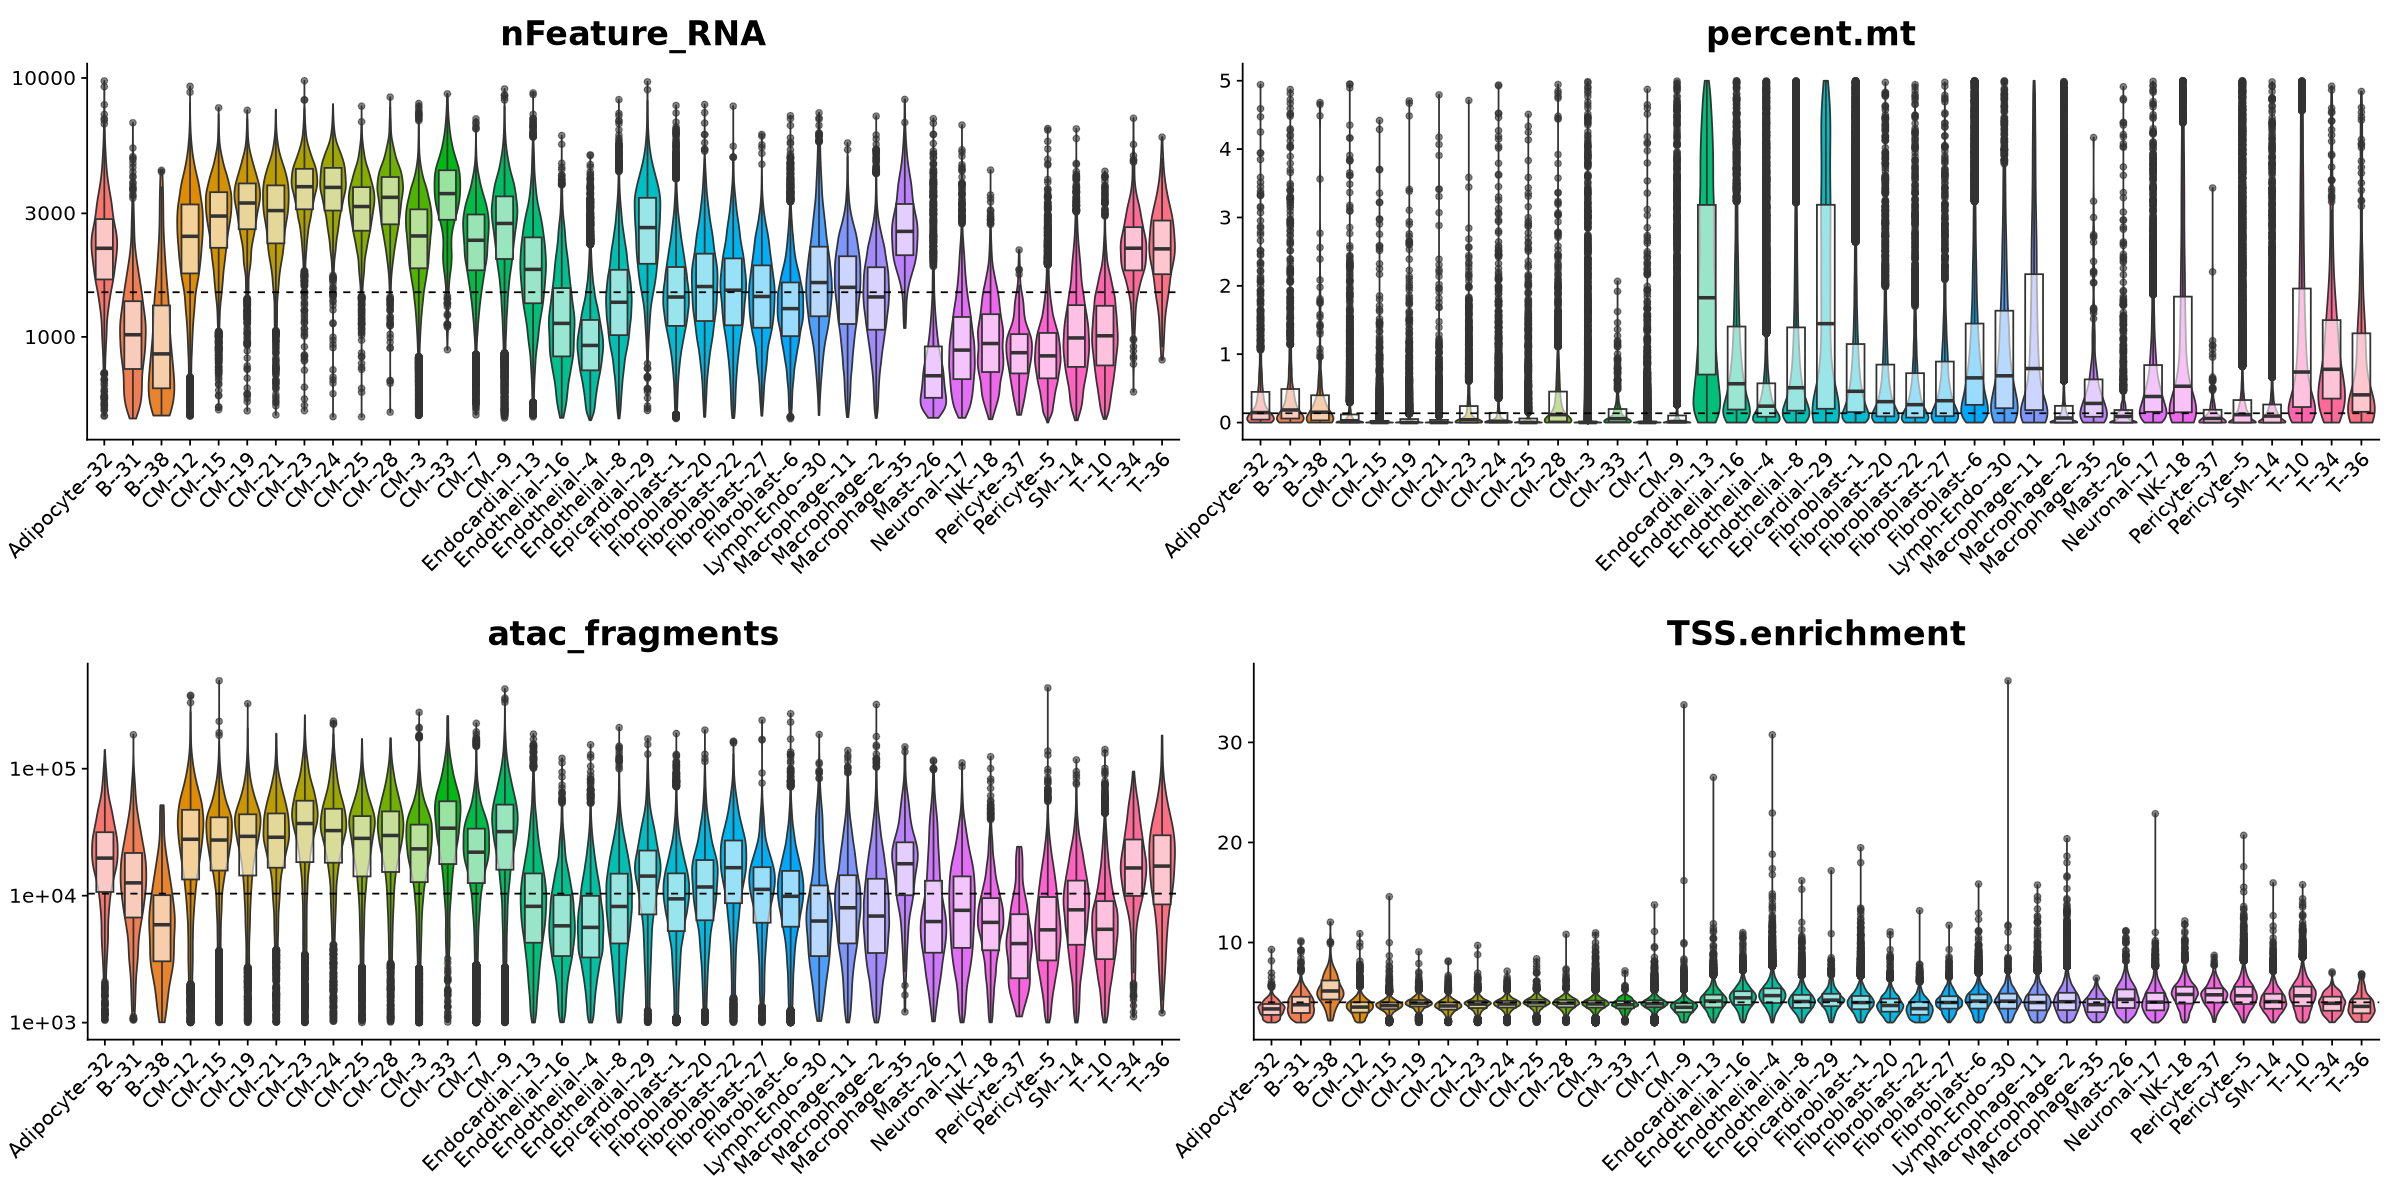

In [20]:
options(repr.plot.height = 10, repr.plot.width = 20)
ggarrange(p1, p2, p3, p4, 
          ncol = 2, nrow = 2,
          common.legend = TRUE,legend="none")